## "Full Stack" Data Science Analysis on Most Anticipated Movies & Score Prediction

### Introduction

For this project, we want to explore the statistics of movies that are most anticipated by audience and critics from 2015-2020 and see if the actual scores and revenues align with people’s expectations. We wonder if some movie native features such as directors or production company as well as public social sentiments before the movie release could be the factors leading to good reputation. We will examine the relationships between the movie attributes with their critic scores and use multiple machine learning models to predict the performance of upcoming movies.

### Overview
* [Part 1 - Data Collection](#part1)

    * [1.1 Discover the Top 100 Most Anticipated Movie From 2015 to 2020](#1.1)
    
    * [1.2 Extract Movie Features](#1.2)
    
    * [1.3 Parse the official movie trailers](#1.3)
    
    * [1.4 Parse Tweets for movies before the releases](#1.4)
    
* [Part 2 - Data Processing](#part2)

    * [2.1 Quantify categorical features](#2.1)
    
    * [2.2 Sentiment analysis of trailer comments](#2.2)
    
* [Part 3 - Data Visualization of Non-quantified Data](#part3)
    
    * [3.1 Visualize Genre Distribution](#3.1)
    
    * [3.2 Explore Rating Distribution](#3.2)
    
    * [3.3 Explore Gross Distribution](#3.3)
    
    * [3.4 Visualize movie trailer comments](#3.4)
    
* [Part 4 - Data Analysis on Quantified Features](#part4)

    * [4.1 Merge Features](#4.1)
    
    * [4.2 Examine Feature Correlation](#4.2)
    
* [Part 5 - Build Machine Learning Models](#part5)

    * [5.1 Linear Model](#5.1)
    
    * [5.2 Non-Linear Model](#5.2)
    
    * [5.3 Non-Parametric Model](#5.3)
    
    * [5.4 Classification Model](#5.4)

* [Part 6 - A Fun Prediction](#part6)


<a id='part1'></a>
### Part 1 - Data Collection

In order to run the code, first we need to install some necessary libraries.

[seaborn](https://seaborn.pydata.org/) is used for plotting.

    $ pip install seaborn
    
[getpass](https://docs.python.org/3/library/getpass.html) is used for portable api key input.

    $ pip install getpass
    
[googleapiclient](https://googleapis.github.io/google-api-python-client/docs/epy/googleapiclient.discovery-module.html) is used for retrieving data using Youtube Data API.

    $ pip install google-api-python-client
    
[stweet](https://github.com/markowanga/stweet) is used for parsing twitter data.

    $ pip install stweet
    
[textblob](https://textblob.readthedocs.io/en/dev/) is used for applying sentiment analysis.

    $ pip install textblob
    
[wordcloud](https://amueller.github.io/word_cloud/) is used for plotting word cloud.

    $ pip install wordcloud

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
from bs4 import BeautifulSoup
import re
from getpass import getpass
import os 
import googleapiclient.discovery
import os.path

import stweet as st
import arrow
from datetime import datetime
import time

# sentiment analysis tool
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS

<a id='1.1'></a>

#### 1.1 Discover the Top 100 Most Anticipated Movie From 2015 to 2020.

To limit our parsed dataset and help for future model processing, we will focus on the ones which gains people's anticipation before their releases. [Playlist](https://theplaylist.net/about-the-playlist/) is a leading film website, providing accessible news and critical voices for film community. This website offers a list of the top 100 most anticipated movie list starting from 2015. IMDb users have also organized Playlist's movie lists and post the lists on IMDb websites (e.g. [link](https://www.imdb.com/list/ls027180287/)). Choosing to parse the IMDb versions allows us to parse the movie's imdb id at the same time, making us easier to extract information for each individual movie.

In [412]:
def get_movie_titles_from_list(year, list_id):
    """ Extract movie names from the most anticipated movie list.
        args:
            movie_list_year
            list_id: imdb list id number
        
        return: a list of dict which contains movie imdb id mapped with its title. 
    """
    
    # retrieve html content 
    list_url = "https://www.imdb.com/list/" + list_id
    response = requests.get(list_url)
    html = BeautifulSoup(response.content, 'html.parser').find("body")
    item_sections = html.find_all("div", class_="lister-item mode-detail")
    
    movie_list = []
    # iterate each section to retrieve movie name and id
    for item in item_sections:
        movie_href = item.find("h3", class_="lister-item-header").find("a")
        movie_dict = {}
        movie_dict["title"] = movie_href.text
        if movie_dict['title'] == 'Life':
            movie_dict['title'] += " (" + str(year) + ")"
        movie_link = movie_href.get('href')
        movie_dict["imdb_id"] = movie_link.split("/")[2]
        
        movie_list.append(movie_dict)

    return movie_list

In [413]:
# IMDb movie list ids
anticipated_movie_lists = {2015: "ls073205935", 2016: "ls031241950",
                          2017: "ls066252200", 2018: "ls027180287", 2019: "ls047748052",
                          2020: "ls091680730"}

def get_movies_from_lists(movie_list_dict):
    """ Extract movies from a list of anticipated movie list
    
    args: 
        movie_list_dict: a dictionary which contains the movie list id for a year
        
    return: a list of dict which contains movie imdb id mapped with its title
    """
    
    movie_list = []
    for year, list_id in movie_list_dict.items():
        cur_year_list = get_movie_titles_from_list(year, list_id)
        movie_list.extend(cur_year_list)
    
    return movie_list  

if anticipated
complete_movie_list = get_movies_from_lists(anticipated_movie_lists)

In [414]:
df_anticipated_movies = pd.DataFrame(complete_movie_list)
df_anticipated_movies.head(3)

,title,imdb_id
0,Pride and Prejudice and Zombies,tt1374989
1,American Ultra,tt3316948
2,Jane Got a Gun,tt2140037


<a id='1.2'></a>
#### 1.2 Extract Movie Features

The movie attributes we are interested in explore include: `genres`, `director`, `stars`,  `production_company`, `budget`, `date_realeased`. Beside, we want to dive into the relationship between these attributes and target varibles such as `Gross USA`, `Worldwide Gross`, `IMDb rating` and `Metascore`. Being aware that some movies could be in pre-production or post-production stages due to COVID impact and considering movies at those stages will not likely have trailers online which will be analyzed in later sections, we will not extract features for them.

In [420]:
def extract_movie_details(movie_id):
    """ Extract movie feature variables from IMDb websites.
    
    args:
        movie_id: IMDb id for a movie
    
    return: a list of dict which contains movie attributes or None if movie is not completed
        
    """
    
    # retrieve html content 
    list_url = "https://www.imdb.com/title/" + movie_id
    response = requests.get(list_url)
    html = BeautifulSoup(response.content, 'html.parser').find("body")
    
    movie = {}
    
    # Check the movie status message; return none if the movie is not coming soon
    status = html.find("h4", class_="status-message-heading")
    if status:
        if status.text != "Coming Soon" and status.text != "Completed":
            return None
    
    # parse all related movie catogories; join them with '|'
    storyline = html.find("div", attrs={"id": "titleStoryLine"})
    
    # parse generes either from detaisl section or from titile bar 
    if storyline:
        genres = storyline.find("h4", text="Genres:").parent
        movie["genres"] = "|".join([genre.text.strip() for genre in genres.find_all("a")])
    else:
        subtitle = html.find("div", class_ = "subtext").find_all("a", href="/search/")
        movie["genres"] = "|".join([genre.text.strip() for genre in subtitle])
    
    # parse director and stars 
    credits = html.find_all("div", class_="credit_summary_item")
    directors = credits[0].find_all("a", href=re.compile("name"))
    movie['director'] = "|".join([director.text.strip() for director in directors]) 
    stars = credits[2].find_all("a", href=re.compile("name"))
    movie['stars'] = "|".join([star.text.strip() for star in stars])
    
    # parse release_date, production co. budget, gross USA and gross worldwide
    detail_section = html.find("div", attrs={"id": "titleDetails"})
    
    release_date = detail_section.find("h4", text="Release Date:").parent \
                        .text.split("\n")[1].split(":")[1].strip()
    movie['release_date'] = release_date.split(" (")[0]
    
    # some movie entry may missing budget summary
    try:
        budget = detail_section.find("h4", text="Budget:")
        movie['budget'] = int(budget.parent.text.split("\n")[1].split("$")[1].replace(",", ""))
    except:
        movie['budget'] = int(0)
    
    # non-released movies do not have gross 
    try:
        gross_USA = detail_section.find("h4", text="Gross USA:")
        gross_world = detail_section.find("h4", text="Cumulative Worldwide Gross:")
        movie['gross_USA'] = int(gross_USA.parent.text.split("\n")[1].split("$")[1].replace(",", ""))
        movie['gross_world'] = int(gross_world.parent.text.split("\n")[1].split("$")[1].replace(",", ""))
    except:
        movie['gross_USA'] = int(0)
        movie['gross_world'] = int(0)
    
    try:
        production_co = detail_section.find("h4", text="Production Co:").parent
        movie['production_co'] = "|".join([co.text.strip() \
                            for co in production_co.find_all("a", href=re.compile("/company/"))])
    except:
        movie['production_co'] = ""
    
    
    # parse IMDb rating and Metascore (Note: non-released movies do not have scores yet)
    try:
        movie['imdb_score'] = float(html.find("span", attrs={"itemprop": "ratingValue"}).text)
        movie['critic_score'] = int(html.find("div", class_="metacriticScore").text) 
    except:
        movie['imdb_score'] = float(0.0)
        movie['critic_score'] = int(0)
    
    return movie

In [421]:
# do a dry-run on one movie
extract_movie_details("tt2271563")

{'genres': 'Action|Drama|Western',
 'director': 'Jon Cassar',
 'stars': 'Esther Purves-Smith|Kiefer Sutherland|Donald Sutherland',
 'release_date': '19 February 2016',
 'budget': 11000000,
 'gross_USA': 0,
 'gross_world': 0,
 'production_co': 'Minds Eye Entertainment|Panacea Entertainment|Moving Pictures Media',
 'imdb_score': 6.3,
 'critic_score': 55}

Doing some movie page inspection, we noticed that some movies are mapped to the wrong imdb ids. We manually created a dict to map the old imdb id to the new one.

In [426]:
new_mapping = {"tt1606774": "tt2271563", "tt5318674": "tt5881528"}

def create_movie_dataset(movies, new_mapping):
    """ Extract movie features for all the movies in the list, remove duplicated ones and filter out
        the ones with little information post on IMDb.
    
        This function will also correct the movie id and map movie title to the new imdb ids.
        
    args:
        movies: a list of dict of movie titles with movie imdb ids
        new_mapping: new mapping from old imdb id to new one
        
    """
    
    # create a set for filtering out existing movies
    imdb_ids = set()
    movie_data = []
    for movie in movies:
        cur_movie_data = {}
        cur_movie_data.update(movie)
        
        # if movie has already been processed; neglect it
        if movie['imdb_id'] in imdb_ids:
            continue
        
        # if movie has a new mapping
        if movie['imdb_id'] in new_mapping:
            movie['imdb_id'] = new_mapping[movie['imdb_id']]
              
        try:
            movie_features = extract_movie_details(movie['imdb_id'])
            if movie_features:
                cur_movie_data.update(movie_features)
                movie_data.append(cur_movie_data)
                
            # udpate the unique set
            imdb_ids.add(movie['imdb_id'])
        except:
            # do nothing; simply neglect the movies with too little information
            continue
    
    return movie_data

# scrape data if local file 'movie_features.csv' does not exit
if os.path.isfile('movie_features.csv'):
    print ("File exist")
    df_movies = pd.read_csv("movie_features.csv", index_col = 0)
else:
    print ("File not exist. Scraping data .....")
    movie_data = create_movie_dataset(complete_movie_list, new_mapping)
    df_movies = pd.DataFrame(movie_data)
    # export it as csv file 
    df_movies.to_csv("movie_features.csv")

File exist


In [427]:
df_movies.head(3)

,title,imdb_id,genres,director,stars,release_date,budget,gross_USA,gross_world,production_co,imdb_score,critic_score
0,Pride and Prejudice and Zombies,tt1374989,Action|Comedy|Fantasy|Horror|Romance,Burr Steers,Lily James|Sam Riley|Jack Huston,5 February 2016,28000000,10938134,16457494,Cross Creek Pictures|MadRiver Pictures|QC Ente...,5.8,45
1,American Ultra,tt3316948,Action|Comedy,Nima Nourizadeh,Jesse Eisenberg|Kristen Stewart|Connie Britton,21 August 2015,28000000,14440985,27262374,PalmStar Media|FilmNation Entertainment|Likely...,6.1,50
2,Jane Got a Gun,tt2140037,Action|Drama|Western,Gavin O'Connor,Natalie Portman|Joel Edgerton|Ewan McGregor,29 January 2016,25000000,1513793,3067531,1821 Pictures|Boies / Schiller Film Group|Eave...,5.9,49


<a id='1.3'></a>
#### 1.3 Parse the official movie trailers

To collect public sentiment data towards a movie before its release, the comment section of its movie trailer is a good data source to investigate poeple's expectations. Before extracting comments for a movie trailer, we need to figure out which official trailer on Youtube we want to explore. We decide to pick the top search entry as our research item after we enter `movie name + official trailer` in the Youtube search bar. Then we extract the comment threads from the picked trailers. The mapping of movie title to its trailer's Youtube video id will be saved into a local csv file called `movie_trailer_id`.

In [428]:
def get_official_trailer_id(movie_name):
    """
    Extract the first found official trailer video for a movie
    
    args:
        movie_name: the name of the movie
    
    return: the Youtube Video id for the official trailer
    
    """
    
    YOUTUBE_SEARCH_PAGE = "https://www.youtube.com/results?search_query="
    url = YOUTUBE_SEARCH_PAGE + movie_name.replace(" ", "+") + "+official+trailer"
    
    response = requests.get(url)
    html = BeautifulSoup(response.content, 'html.parser').find("body")
    
    # locate the javascript containing all video queries
    script = html.find('script', string=re.compile(r'^var ytInitialData\s*')).string

    # use regular expression to find video ids
    first_entry = re.search(re.compile(r'videoId":"([a-zA-Z0-9]+)","thumbnail'), script)
    video_id = first_entry[1]

    return video_id

In [451]:
def parse_movie_trailers(movie_title_list):
    """ Extract the movie trailer for every movie in the list
    
    args: 
        movie_title_list: a list of contains movie titles
    
    return: a list dict of youtube movie trailer mapping to each individial movie
    """
    
    movie_trailer = []
    for title in movie_title_list:
        cur_trailer = {}
        cur_trailer['title'] = title
        
        # call previous function to get the youtube video id for the first-found trailer
        cur_trailer['trailer_id'] = get_official_trailer_id(title)
        movie_trailer.append(cur_trailer)
    
    return movie_trailer    

# scrape data if local file 'movie_trailer_id.csv' does not exit
if os.path.isfile('movie_trailer_id.csv'):
    print ("File exist")
    df_trailers = pd.read_csv("movie_trailer_id.csv", index_col = 0)
else:
    print ("File not exist. Scraping data .....")
    mvoie_trailers = parse_movie_trailers(list(df_movies['title']))
    df_trailers = pd.DataFrame(mvoie_trailers)
    df_trailers.to_csv("movie_trailer_id.csv")

File exist


In [452]:
df_trailers.head(3)

,title,trailer_id
0,Pride and Prejudice and Zombies,foGraEVNI0s
1,American Ultra,bLGFwkRx2HA
2,Jane Got a Gun,fm7qxI3gmpw


In [435]:
# Since the Youtube video page is rendered dynamically by Javascript
# we will use Youtube Data API to scrape up to 500 the most relevant comments for one movie trailer. 
# (Note: a valid API key is needed before using this API).

youtube_api_key = getpass('Enter Your API key here')
print ('Your API key is successfully saved!')

Enter Your API key here········
Your API key is successfully saved!


In [436]:
# Reference: the code is adapted from the example code found on the API doc
def build_service(api_secret):
    # Disable OAuth verification
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
    api_name = "youtube"
    api_version = "v3"
    KEY = api_secret

    # construct the api service
    youtube = googleapiclient.discovery.build(
        api_name, api_version, developerKey = KEY)
    return youtube


def extract_comments(movie_title, video_id, api_secret):
    """ This function is used to retrieve the most relevant comments 
        below a specified YouTube video. It will only parse the first 500 comments.
        (around 5 pages of replies)
    
    args:
        movie_title: movie_name
        video_id:  YouTube video id
        api_secret: YouTube API key

    return: a list of dict of video title with one of its comments
    """
    total_comments = []
    
    youtube = build_service(api_secret)

    # send the request to retrieve 100 comments at one time
    response = youtube.commentThreads().list(
            part="snippet,replies",
            videoId = video_id,
            maxResults = 100,
            order = 'relevance',
            textFormat = 'plainText'
        ).execute()
    
    page_num = 1;
    MAX_PAGES = 5;
    
    while response:
        # iterate each response comment entry
        comments = [{"title": movie_title, "trailer_id": video_id,
                     "comment": comment['snippet']['topLevelComment']['snippet']['textDisplay']} \
                for comment in response['items']]
        total_comments.extend(comments)
        
        # retrieve the next page comments
        if 'nextPageToken' in response and page_num < MAX_PAGES:
            response = youtube.commentThreads().list(
                    part="snippet,replies",
                    videoId = video_id,
                    pageToken = response['nextPageToken'],
                    maxResults = 100,
                    order = 'relevance',
                    textFormat = 'plainText'
                ).execute()
            page_num += 1;
        
        else:
            break;
    
    return total_comments

In [437]:
# do a dry-run on movie 'US' released in 2019
US_comments = extract_comments("US", "1tzFRIQfwXg", youtube_api_key)
print(str(len(US_comments)) + " comments are retrieved")
print("The top 10 relevant comments are: ")
print([entry['comment'] for entry in US_comments[:10]])

500 comments are retrieved
The top 10 relevant comments are: 
['Here is the first trailer from Jordan Peele´s (Get Out) new movie "Us"', 'how did he manage to turn "I got 5 on it" into a horror song', "My theory is that they're gonna make a movie called HELP\n\n\n\nHELP      US      GET OUT", 'Lol am i the only who doesnt know who Danplan is', 'I would be scared of looking in the mirror after watching this', '2:17 when you fart in class and everyone looks at the person next to you', 'This I need to see 😌', "Who else ISN'T here from DanPlan?", 'Can we just talk about how beautiful the mother is ?!', 'anyone here from danplan??']


During the first dry-run of the following function, we notice that some movie trailers has disabled its comments. For example, all Pixar's movie trailers disallowed audience to leave comments. Given by the fact that a movie usually realeased mutiple trailers on Youtube and different production companies will realease its own version, one strategy to fix missing data is manually replacing the trailer id with the id of another movie trailer on Youtube with a similar thumb-up ratio. 

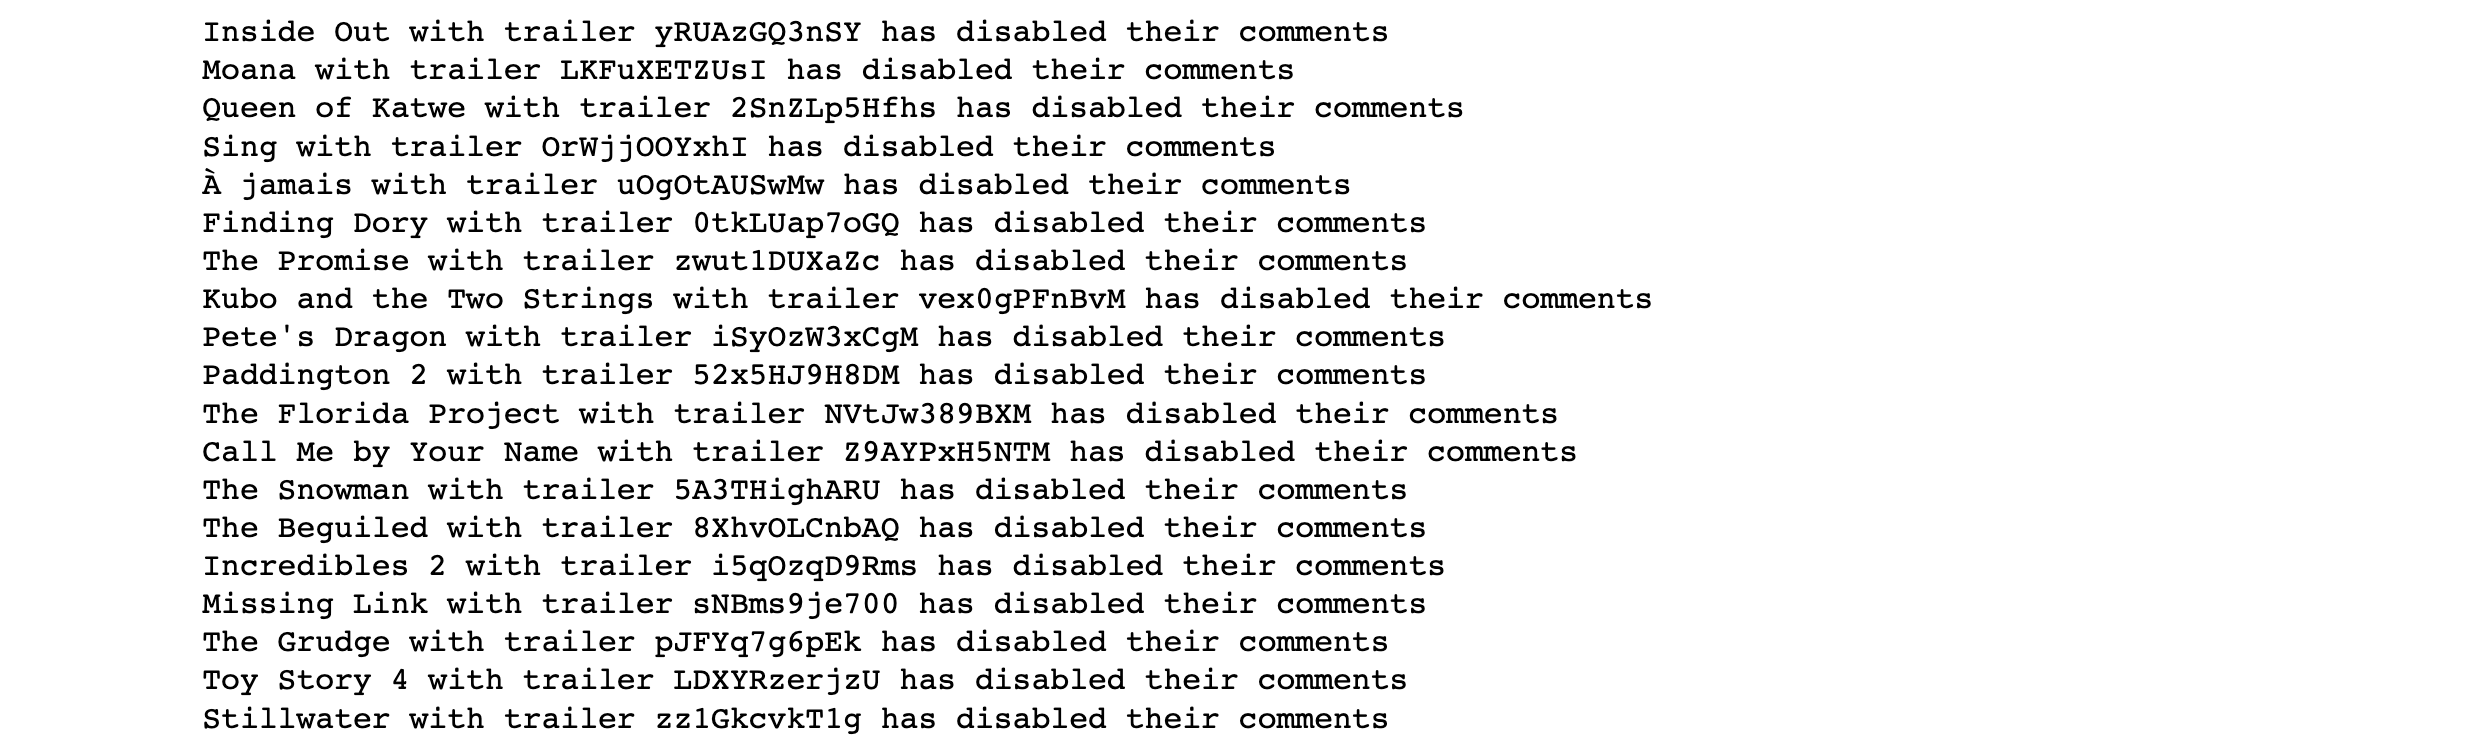

In [438]:
# Manually replece the trailers with comments disabled
trailer_replacement = {"yRUAzGQ3nSY": "kAgJcEmMTek", "LKFuXETZUsI": "C6PbWhWGUrY", 
                       "2SnZLp5Hfhs": "z4l3-_yub5A", "OrWjjOOYxhI": "va9mGwngAfM",
                       "uOgOtAUSwMw": "Qe0mfHiMpXw", "0tkLUap7oGQ": "JhvrQeY3doI",
                       "zwut1DUXaZc": "C5LBCIHOykk", "iSyOzW3xCgM": "fPOamb6d_20",
                       "52x5HJ9H8DM": "5B6A0UrYJsk", "NVtJw389BXM": "WwQ-NH1rRT4",
                       "Z9AYPxH5NTM": "1f0nlxUr_iM", "5A3THighARU": "BF2Ksrxu_QY",
                       "8XhvOLCnbAQ": "iBoLK5z_FHo", "i5qOzqD9Rms": "JwwY8gx_2LA",
                       "sNBms9je700": "vM5VC7nCv_Y", "pJFYq7g6pEk": "O2NKzO-fxwQ",
                       "LDXYRzerjzU": "HxXY4dv3ILQ", "zz1GkcvkT1g": "HxXY4dv3ILQ", "SqxoT7hqUVE" : "cuA-xqBw4jE"}

In [457]:
# Extract comments for every movie Qe0mfHiMpXwthe df_movies dataset
def parse_all_comments(trailer_list, trailer_replacement):
    """ Extract 500 comments for all trailers in the list 
    
    args:
        trailer_list: a list of dict of movie title and its trailer's Youtube video id
        trailer_replacement: a dict of mapping from old trailer id to the new one
        
    returns: a list of dict of movie title mapping to trailer id and one of its comments
    """
    
    comment_data = []
    
    for movie in trailer_list:
        # Note some movies may have disabled their trailers:
        try:
            trailer_id = movie['trailer_id']
            if trailer_id in trailer_replacement:
                trailer_id = trailer_replacement[trailer_id]
            comment_data.extend(extract_comments(movie["title"], trailer_id, youtube_api_key))
        except googleapiclient.errors.HttpError:
            print(movie["title"] + " with trailer " + trailer_id + " has disabled their comments");
    
    return comment_data

# scrape data if local file 'movie_trailer_comments.csv' does not exit
if os.path.isfile('movie_trailer_comments.csv'):
    print ("File exist")
    df_trailer_comments = pd.read_csv('movie_trailer_comments.csv', index_col = 0, lineterminator='\n')
else:
    print ("File not exist. Scraping data .....")
    movie_comments = parse_all_comments(df_trailers.to_dict('records'), trailer_replacement)
    df_trailer_comments = pd.DataFrame(movie_comments)
    df_trailer_comments.to_csv("movie_trailer_comments.csv")

File exist


In [458]:
df_trailer_comments.head(3)

,title,trailer_id,comment
0,Pride and Prejudice and Zombies,foGraEVNI0s,Abraham Lincoln the vampire hunter... what´s ...
1,Pride and Prejudice and Zombies,foGraEVNI0s,I wonder how Jane Austen would react to this.
2,Pride and Prejudice and Zombies,foGraEVNI0s,"Ok, at first i was like ""ah this looks dumb, h..."


<a id='1.4'></a>
#### 1.4 Parse Tweets for movies before the releases

Twitter is another source where we can examine people's opinions for a movie. The official [Twitter API](https://developer.twitter.com/en/docs/twitter-api) has so many limitations. It only provides data in 7 days and limits the total data we can scrape. Therefore, we have to find some other ways better than twitter API. Finally, we used a third-party library called `stweets` to extract top related tweets of movies before their release dates in order to discover the social anticipation before movies comming out.

In [459]:
def extract_tweets(movie_title, movie_release_date):
    """ Extract the first 500 tweets of a specified movie before its release date
    
    args: 
        movie_title: name of the movie
        movie_release_date: the release date of the input movie
        
    return: a list of dict of movie name and one of its related tweet
    """
    # convert time to the correct ISO format
    iso_date = datetime.strptime(movie_release_date, "%d %B %Y").isoformat()
    
    task = st.SearchTweetsTask(
        movie_title + " Movie", 
        until = arrow.get(iso_date),
        tweets_limit = 500)

    tweets_collector = st.CollectorTweetOutput()

    st.TweetSearchRunner(
        search_tweets_task = task,
        tweet_outputs = [tweets_collector]
    ).run()

    tweets = tweets_collector.get_scrapped_tweets()
    
    tweets_text = [{"title": movie_title, "comment": tweet.full_text} for tweet in tweets]
    
    return tweets_text

In [460]:
# do a dry-run by extracting tweets for movie "Pride And Prejudice And Zombies Movie"
extract_tweets("Pride And Prejudice And Zombies", "5 February 2016")[300:303]

[{'title': 'Pride And Prejudice And Zombies',
  'comment': 'I wonder what Janet thinks about the Pride and prejudice and zombies movie. Could have been an interesting read in AP lit'},
 {'title': 'Pride And Prejudice And Zombies',
  'comment': "Pride and Prejudice and Zombies is one of those movies that looks so bad that I'm not even sure if @talkhoops would watch it"},
 {'title': 'Pride And Prejudice And Zombies',
  'comment': 'Pride and Prejudice and Zombies was a fun movie. It was interesting watching the classic with a little twist.'}]

In [461]:
def parse_all_tweets(movie_date):
    """ Parse tweets for every movie in the input list
    
    args:
        movie_data: a list of dict of movie features including movie title and release date
    
    return: a list of dict of movie name and one of its related tweet  
    """
    total_tweets = []
    
    for movie in movie_date:
        try:
            total_tweets.extend(extract_tweets(movie["title"], movie["release_date"]))
        except:
            print(movie["title"] + " does not have related tweets")
        
    return total_tweets

# scrape data if local file 'movie_tweets.csv' does not exit
if os.path.isfile('movie_tweets.csv'):
    print ("File exist")
    df_movie_tweets = pd.read_csv('movie_tweets.csv', index_col = 0, lineterminator='\n')
else:
    print ("File not exist. Scraping data .....")
    movie_tweets = parse_all_tweets(df_movies.to_dict('records'))
    df_movie_tweets = pd.DataFrame(movie_tweets)
    df_movie_tweets.to_csv("movie_tweets.csv")

File exist


In [462]:
df_movie_tweets.tail()

,title,comment
232024,Tenet,https://t.co/O90F7lqITX info Tenet Exclusive F...
232025,Tenet,"if u nasty, I saw TENET and threaded some Take..."
232026,Tenet,Tenet was quintessential Nolan. Plot driven mo...
232027,Tenet,@KOPF_STOFF I never had issues with other Nola...
232028,Tenet,Tom Cruise Goes Undercover To See ‘Tenet’ At M...


#### 1.5 Parse movie trailer ratings

Considering some people may only click on rating buttons instead of leaving a full comment, we also parse the thumb-up and thumb-down counts of those movie trailers using the Youtube Data API.

In [463]:
def parse_trailer_rating(video_id, api_secret):
    """ Extract the like and dislike number from the input Youtube video
    
    args:
        video_id: str, Youtube Video Id
        api_secret: str, unqiue Youtube API secret
    
    return: like_count, dislike_count 
    """
    youtube = build_service(api_secret)
    
    request = youtube.videos().list(
        part="statistics",
        id=video_id
    )
    response = request.execute()['items'][0]['statistics']
    

    return response.get('likeCount'), response.get('dislikeCount')

In [344]:
parse_trailer_rating("foGraEVNI0s", youtube_api_key)

('37813', '4237')

In [464]:
def extract_all_trailer_ratings(trailer_list, trailer_replacement):
    rating_data = []
    
    for movie in trailer_list:
        try:
            trailer_id = movie['trailer_id']
            if trailer_id in trailer_replacement:
                trailer_id = trailer_replacement[trailer_id]
            like, dislike = parse_trailer_rating(trailer_id, youtube_api_key)
            
            rating_data.append({"title":movie['title'], "trailer_id": trailer_id,"like_counts": like, "dislike_counts": dislike})
        except googleapiclient.errors.HttpError:
            print(movie["title"] + " with trailer " + trailer_id + " does not have likecount data");
    
    return rating_data

trailer_ratings = extract_all_trailer_ratings(df_trailers.to_dict('records'), trailer_replacement)

df_trailer_ratings = pd.DataFrame(trailer_ratings)
df_trailer_ratings.to_csv("movie_trailer_ratings.csv")

In [77]:
df_trailer_ratings = pd.read_csv("movie_trailer_ratings.csv", lineterminator='\n', index_col=0)
df_trailer_ratings.head(3)

,title,trailer_id,like_counts,dislike_counts
0,Pride and Prejudice and Zombies,foGraEVNI0s,37816.0,4237.0
1,American Ultra,bLGFwkRx2HA,31088.0,876.0
2,Jane Got a Gun,fm7qxI3gmpw,2506.0,291.0


<a id='part2'></a>
### Part 2 - Data Processing

<a id='2.1'></a>
#### 2.1. Quantify categorical features

The movie features contain lots of categorical such as `stars`, `directors`, `production_co` and `genres`. Considering these variables could have different popularity scores or public images (e.g. some directors have always produced high-quality movies so people have high expectations on them), instead of applying simple one-hot-encoding, we hope to quantify these variables. We have found a website called [metacritic](https://www.metacritic.com/) where we can scrape and extract critics' ratings of actors or directors or even production companies in one place. 

In [466]:
df_movies = pd.read_csv("movie_features.csv")

Since there are only limited numbers of genres, we can quantify genres first. One movie can have different genres, here we just use mean value of all the genres for one movie to represent its genres score.

In [12]:
def find_all_genres(movie_features):
    """ This function extract and organize all the possible movie genres
    
    args: 
        movie_features: pandas dataframe of movie data which contains all the features
    return: a dict of genres_map:
                key: genre
                value: avg_score of 100 recent movies in this genre
    """
    user_agent = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}
    genres_set =set()
    for i in range(len(movie_features)):
        temp = movie_features.loc[i]
        genres = temp['genres'].split('|')
        for j in genres:
            genres_set.add(j)
            
    # key:genre value:avg_score of 100 recent moives in this genre
    genres_map = {} 
    for i in genres_set:
        genres_score = 0
        count = 0
        i = i.lower()
        this_url = 'https://www.metacritic.com/browse/movies/genre/date/'+i+'?view=detailed'
        response = requests.get(this_url, headers = user_agent)
        soup = BeautifulSoup(response.text, 'html.parser')
        for j in soup.find_all('div',{'class':re.compile('metascore_w large movie *')}):
            genres_score += int(j.text)
            count += 1
        genres_score /= count
        genres_map[i] = round(genres_score,2)
        
        time.sleep(0.3)
        
    return genres_map

# Un-comment the following code if you would like to re-calculate genre scores
# movie_genres_dict = find_all_genres(df_movies)
# print(movie_genres_dict)

{'horror': 57.36, 'war': 62.38, 'drama': 63.55, 'music': 65.83, 'comedy': 55.57, 'fantasy': 57.22, 'sport': 60.37, 'mystery': 55.67, 'family': 56.95, 'adventure': 55.06, 'thriller': 53.9, 'western': 60.67, 'crime': 56.65, 'documentary': 71.42, 'musical': 58.87, 'action': 51.26, 'history': 64.6, 'animation': 63.16, 'sci-fi': 57.48, 'biography': 65.09, 'romance': 55.57}


In [467]:
# Since we have to construct specific urls to scrape data from websites, 
# we need to figure out the characteristic of metacritic's urls. 
# Turns out metacritic's url only contains English letters and digits. 
# Therefore, we have to convert some special characters into English letters. 
# We use regular expressions to find and transform special characters.
def reshape(name):
    """ This function is a helper function which converts spanish character to english letter.
    
    args:
        name: actor name or director name 
    
    return: str, the english version of the name in lower case
    """
    name = re.sub(r'[ ]',r'-',name) #Gilles Paquet-Brenner -> gilles-paquet-brenner
    if re.match(r'^[A-Za-z-]+$',name):
        return name.lower()
    
    name = re.sub(r'\'',r'',name) #Gavin O'Connor -> gavin-oconnor
    name = re.sub(r'\.',r'',name) #David O. Russell -> david-o-russell
    name = re.sub(r'é',r'e',name) #Cédric Jimenez -> cedric-jimenez
    name = re.sub(r'á',r'a',name) #Baltasar Kormákur -> baltasar-kormakur
    name = re.sub(r'í',r'i',name) #Pablo Larraín -> pablo-larrain
    name = re.sub(r'ä',r'a',name) #Aki Kaurismäki -> aki-kaurismaki
    name = re.sub(r'ó',r'o',name) #Alfonso Cuarón -> alfonso-cuaron
    name = re.sub(r'ô',r'o',name) #David Michôd -> david-michod
    name = re.sub(r'Ö',r'',name)  #Ruben Östlund -> ruben-stlund
    name = re.sub(r'ø',r'o',name) #Mia Hansen-Løve -> mia-hansen-love
    name = re.sub(r'î',r'i',name) #Benoît Jacquot -> benoit-jacquot
    name = re.sub(r'ñ',r'o',name) #Alejandro G. Iñárritu -> alejandro-gonzalez-ioarritu
    name = re.sub(r'å',r'a',name) #Stellan Skarsgård -> stellan-skarsgard
    name = re.sub(r'ë',r'e',name) #Zoë Kravitz -> zoe-kravitz
    name = re.sub(r'ü',r'u',name) #Daniel Brühl -> daniel-bruhl
    name = re.sub(r'ï',r'i',name) #Shaïn Boumedine -> shain-boumedine
    name = re.sub(r'è',r'e',name) #Adèle Haenel -> adele-haenel
    name = re.sub(r'à',r'a',name) #Luàna Bajrami -> lusna-bajrami
    name = re.sub(r'ö',r'o',name) #Matthias Schweighöfer -> matthias-schweighofer
    #additional for companies
    name = re.sub(r'&',r'',name)  #Barunson E&A
    name = re.sub(r'\(',r'',name) #British Film Institute (BFI) Production Board
    name = re.sub(r'\)',r'',name) #British Film Institute (BFI) Production Board
    name = re.sub(r'/',r'',name)  #Boies / Schiller Film Group
    name = re.sub(r'ú',r'u',name) #O Som e a Fúria
    name = re.sub(r'ç',r'a',name) #CNC Aide aux cinémas du monde - Institut Français
    name = re.sub(r',',r'',name) #Grisbi Productions, Le
    
    name = re.sub(r'-+','-',name)
    return name.lower()

Now we need to scrape director scores, stars scores and film company scores from metacritic. Since not all the stars or film companies can be found at metacritic, we need to make a plan. One movie has many stars. If more than one star's score can be found at metacritic, we will use the average score of all the stars scores that can be found. If no star of this movie can be found, then we will use -1 to represent the star score. We deal with other attributes in a similar way.

In [1]:
# The following function is very very time-consuming. It takes more than 5 hours to run. 
# Therefore, I recommand not running that. Just read data from the csv file we already scraped is better.
def generate_quantified_features(movie_features, genres_map):
    """ This function generates a movie feature dataset with features all quantified
    
    args:
        movie_features: pandas dataframe of movie data which contains all the features
        genres_map: a dict of movie genre mapping to its metacritic score
    
    return: pandas dataframe with quantified features (directors, actors, production_co and genres)
    """
    url = 'https://www.metacritic.com/person/'
    user_agent = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}

    # key:person_name value:person_score
    score_map = {} 
    # score_map for companies
    company_map = {} 
    
    for i in range(len(movie_features)):
        temp = movie_features.loc[i]
        #scrape director score
        directors = temp['director'].split('|')
        director_score = 0
        for j in directors:
            if j in score_map:
                director_score += score_map[j]
                continue
            #joint url and person_name
            this_url = url+reshape(j)
            #connect to url

            flag = True
            times = 0
            while flag and times<5:
                times+=1
                try:
                    time.sleep(0.2)
                    response = requests.get(this_url, headers = user_agent)
                    soup = BeautifulSoup(response.text, 'html.parser')
                    #get person_avg_score
                    try:
                        parent = soup.find('div',{'class':'score_details personscore_details'})
                        this_score = parent.find('span',{'class':re.compile('data textscore textscore_')}).text
                        score_map[j] = float(this_score)
                        director_score += score_map[j]
                        flag = False
                    except:
                        if times==5:
                            print(temp['title']+' Can not find director avg_score for '+j+', '+this_url)
                except:
                    if times==5:
                        print(temp['title']+' Can not connect to '+this_url)

        director_score /= len(directors)
        if director_score==0:
            director_score=-1
        #print(director_score)
        movie_features.loc[i,'director'] = round(director_score,2)

        #scrape star score
        stars = temp['stars'].split('|')
        stars_score = 0
        for j in stars:
            if j in score_map:
                stars_score += score_map[j]
                continue
            #joint url and person_name
            this_url = url+reshape(j)
            #connect to url
            flag = True
            times = 0
            while flag and times<5:
                times+=1
                try:
                    time.sleep(0.2)
                    response = requests.get(this_url, headers = user_agent)
                    soup = BeautifulSoup(response.text, 'html.parser')
                    #get person_avg_score
                    try:
                        parent = soup.find('div',{'class':'score_details personscore_details'})
                        this_score = parent.find('span',{'class':re.compile('data textscore textscore_')}).text
                        score_map[j] = float(this_score)
                        stars_score += score_map[j]
                        flag = False
                    except:
                        if times==5:
                            print(temp['title']+' Can not find star avg_score for '+j+', '+this_url)
                except:
                    if times==5:
                        print(temp['title']+' Can not connect to '+this_url)
        stars_score /= len(stars)
        if stars_score==0:
            stars_score=-1
        #print(stars_score)
        movie_features.loc[i,'stars'] = round(stars_score,2)

        company_url = 'https://www.metacritic.com/company/'
        #process NaN value
        if pd.isnull(temp['production_co']):
            companies = []
        else:
            companies = temp['production_co'].split('|')
        companies_score = 0
        for j in companies:
            if j in company_map:
                companies_score += company_map[j]
                continue
            #joint url and person_name
            this_url = company_url+reshape(j)
            #connect to url
            flag = True
            times = 0
            while flag and times<5:
                times+=1
                try:
                    time.sleep(0.2)
                    response = requests.get(this_url, headers = user_agent)
                    soup = BeautifulSoup(response.text, 'html.parser')
                    #get person_avg_score
                    try:
                        parent = soup.find('div',{'class':'score_details personscore_details'})
                        this_score = parent.find('span',{'class':re.compile('data textscore textscore_')}).text
                        company_map[j] = float(this_score)
                        companies_score += company_map[j]
                        flag = False
                    except:
                        if times==5:
                            print(temp['title']+' Can not find company avg_score for '+j+', '+this_url)
                except:
                    if times==5:
                        print(temp['title']+' Can not connect to '+this_url)
        if len(companies)==0:
            companies_score=-1
        else:
            companies_score /= len(companies)
            if companies_score==0:
                companies_score=-1
        #print(companies_score)
        movie_features.loc[i,'production_co'] = round(companies_score,2)

        genres = temp['genres'].split('|')
        genres_score = 0
        for j in genres:
            genres_score += genres_map[j.lower()]
        genres_score /= len(genres)
        movie_features.loc[i,'genres'] = round(genres_score,2)
        print('task '+str(i)+' is done')
        
    return movie_features

In [80]:
# The above method was running in a different laptop. The collected data is stored in local csv file shown below.
df_movies_quantified = pd.read_csv("movie_features_quantified.csv", index_col = 0)
df_movies_quantified.head(3)

,Unnamed: 0.1,title,imdb_id,genres,director,stars,release_date,budget,gross_USA,gross_world,production_co,imdb_score,critic_score
0,0,Pride and Prejudice and Zombies,tt1374989,55.40,53.0,56.00,5-Feb-16,28000000,10938134,16457494,60.67,5.8,45
1,1,American Ultra,tt3316948,53.41,49.0,58.33,21-Aug-15,28000000,14440985,27262374,54.67,6.1,50
2,2,Jane Got a Gun,tt2140037,58.35,56.0,58.67,29-Jan-16,25000000,1513793,3067531,45.33,5.9,49


<a id='2.2'></a>
#### 2.2 Sentiment analysis of trailer comments.

In [474]:
def classify(polarity, subjectivity):
    """ This helper method will classify the comment text based on its polarity 
        and subjectivity score
    
    args:
        polarity: double 
        subjectivity: double
    
    return: str, classification of text sentiment
    """
    # A document with a neutral score may indicate low-emotion doc or mixed emotions.
    if polarity < 0.15 and polarity > -0.15:
        if subjectivity > 0.75:
            return 'Mixed'
        else:
            return 'Neutral'
    if polarity > 0.1:
        return 'Positive'
    else:
        return 'Negative'

def apply_sentiment_analysis(comments):
    '''
    This method analyzes the sentiment for each comment entry in the input
    dataset. 
    args:
        comments: input dataframe containing the comment text
        
    return: an extended dataframe which adds sentiment results to new columns
    '''
    df_sentiment = comments.copy()
    df_sentiment['polarity'] = df_sentiment['comment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_sentiment['subjectivity'] = df_sentiment['comment'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    df_sentiment['sentiment'] = df_sentiment.apply(lambda x : classify(x['polarity'], x['subjectivity']), axis=1)
    return df_sentiment

df_trailer_comments = pd.read_csv("movie_trailer_comments.csv", index_col= 0, lineterminator='\n')
df_trailer_sentiments = apply_sentiment_analysis(df_trailer_comments)

# export as csv file
df_trailer_sentiments.to_csv("movie_trailer_sentiments.csv")

In [71]:
df_trailer_sentiments = pd.read_csv('movie_trailer_sentiments.csv', lineterminator='\n', index_col = 0)

In [475]:
df_trailer_sentiments.sample(10)

,title,trailer_id,comment,polarity,subjectivity,sentiment
81863,Thor: Ragnarok,ue80QwXMRHg,Cate Blanchett...! What more do you need..? ...,0.687500,0.550000,Positive
17925,Equals,6GiU2SSG624,Kirsten deserved an Oscar for this,0.000000,0.000000,Neutral
156496,The World to Come,RhQu4tcHLeU,I wish the movie industry would stop trying to...,0.234643,0.504643,Positive
145868,The Lighthouse,Hyag7lR8CPA,I'm excited to see Robert Pattinson as Batman ...,0.487500,0.825000,Positive
50033,Jackie,g9pW3B8Ycc4,This is the most beautifully put together trai...,0.276667,0.473333,Positive
138790,A Beautiful Day in the Neighborhood,oWWCqes85gQ,Holy shit - this is gonna be a damn tear jerke...,0.150000,0.844444,Positive
134210,Joker,zAGVQLHvwOY,The fact that so many people praised this movi...,0.500000,0.500000,Positive
124685,The Jesus Rolls,lWz8NGIisMo,"""..til it goes ""Click"". LMAO!!",0.937500,1.000000,Positive
39099,Christine,v0itmG80oLI,I just saw the whole movie in 2 minutes.,0.200000,0.400000,Positive
78785,The Glass Castle,bdNiNhSeSDk,Excited.,0.375000,0.750000,Positive


<a id='part3'></a>
### Part 3 - Data Visualization of Non-quantified Data

In this section, we apply some basic data mining techniques to explore the collected non-quantified dataset. We start by analyzing data distribution and trailer comments. The focus of our work is to choose the right visualization types from the seaborn library to present our analysis results

In [476]:
df_movies = pd.read_csv("movie_features.csv", index_col=0)
df_movies.index = df_movies.index.set_names(['id'])
df_movies = df_movies.reset_index()
df_movies.head(3)

,id,title,imdb_id,genres,director,stars,release_date,budget,gross_USA,gross_world,production_co,imdb_score,critic_score
0,0,Pride and Prejudice and Zombies,tt1374989,Action|Comedy|Fantasy|Horror|Romance,Burr Steers,Lily James|Sam Riley|Jack Huston,5 February 2016,28000000,10938134,16457494,Cross Creek Pictures|MadRiver Pictures|QC Ente...,5.8,45
1,1,American Ultra,tt3316948,Action|Comedy,Nima Nourizadeh,Jesse Eisenberg|Kristen Stewart|Connie Britton,21 August 2015,28000000,14440985,27262374,PalmStar Media|FilmNation Entertainment|Likely...,6.1,50
2,2,Jane Got a Gun,tt2140037,Action|Drama|Western,Gavin O'Connor,Natalie Portman|Joel Edgerton|Ewan McGregor,29 January 2016,25000000,1513793,3067531,1821 Pictures|Boies / Schiller Film Group|Eave...,5.9,49


<a id='3.1'></a>
#### 3.1 Visualize Genres Distribution
In this part, we explore what movie genres are most frequently anticipated by the `Playlist` by parsing and counting genres of all movies we have parsed from the `Playelist's` most anticipated movie lists from 2015 to 2020.

In [477]:
# The original dataset has multiple values in 'genre' columns. 
# We need to explode a column into multiple rows
df_single_genres = pd.DataFrame(
        df_movies.genres.str.split('|').tolist(), 
        index = df_movies.id
        ).stack()

# reset df index
df_single_genres = df_single_genres.reset_index([0, 'id'])
df_single_genres.columns = ['id', 'single_genre']

# join with other data
df_single_genres = pd.merge(df_single_genres, df_movies, left_on='id', right_on='id')

df_single_genres.head(3)

,id,single_genre,title,imdb_id,genres,director,stars,release_date,budget,gross_USA,gross_world,production_co,imdb_score,critic_score
0,0,Action,Pride and Prejudice and Zombies,tt1374989,Action|Comedy|Fantasy|Horror|Romance,Burr Steers,Lily James|Sam Riley|Jack Huston,5 February 2016,28000000,10938134,16457494,Cross Creek Pictures|MadRiver Pictures|QC Ente...,5.8,45
1,0,Comedy,Pride and Prejudice and Zombies,tt1374989,Action|Comedy|Fantasy|Horror|Romance,Burr Steers,Lily James|Sam Riley|Jack Huston,5 February 2016,28000000,10938134,16457494,Cross Creek Pictures|MadRiver Pictures|QC Ente...,5.8,45
2,0,Fantasy,Pride and Prejudice and Zombies,tt1374989,Action|Comedy|Fantasy|Horror|Romance,Burr Steers,Lily James|Sam Riley|Jack Huston,5 February 2016,28000000,10938134,16457494,Cross Creek Pictures|MadRiver Pictures|QC Ente...,5.8,45


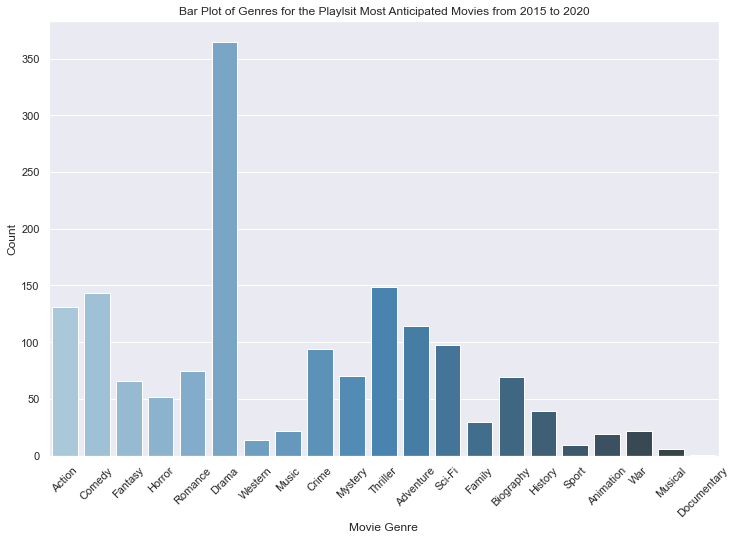

In [478]:
plt.rcParams['figure.figsize'] = 12, 8
plt.figure()

sns.countplot(x = "single_genre", data = df_single_genres, palette=("Blues_d"))

plt.xticks(rotation=45)
plt.xlabel('Movie Genre')
plt.ylabel('Count')
plt.title('Bar Plot of Genres for the Playlsit Most Anticipated Movies from 2015 to 2020')
plt.show()

We find out that drama cateogoris are the most common topics among all other movie genres. It is not a suprising finding since nowadays people have become more picky about movies and a powerful storyline is more likely to gain people's attention. Another reason is that drama genre is easily paired with other movie categories such as action or sci-fi and movies are usually released with multiple labels.

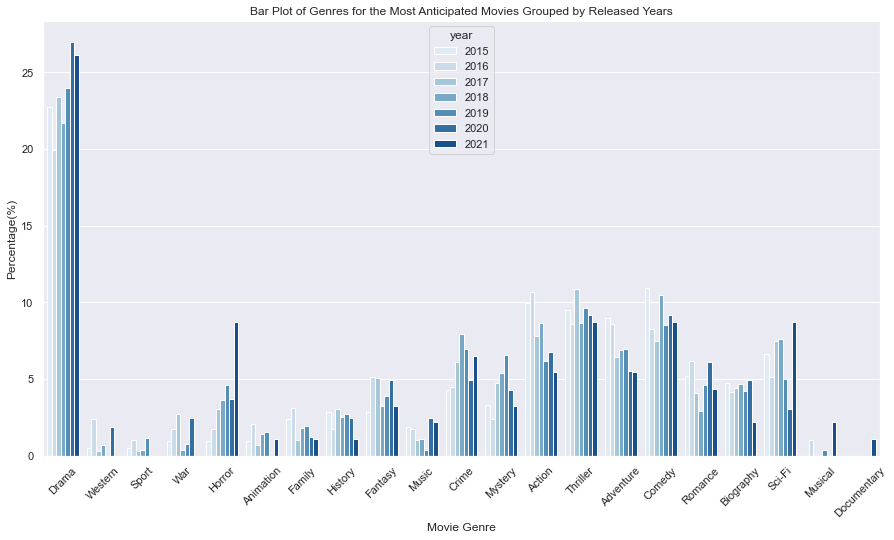

In [479]:
# Group the genres by year to see how each genre's counts vary by years (from 2015 to 2020)
plt.rcParams['figure.figsize'] = 15, 8
df_single_genres['year'] = df_single_genres['release_date'].apply(lambda x : x.split()[-1])

genre_group = (df_single_genres.groupby(['year'])['single_genre']
                    .value_counts(normalize = True) * 100).rename('precentage').reset_index().sort_values(by = 'year')

plt.figure()
sns.barplot(y = "precentage", x = 'single_genre', hue='year', data = genre_group, palette=("Blues"))
plt.xticks(rotation = 45)
plt.xlabel('Movie Genre')
plt.ylabel('Percentage(%)')
plt.title('Bar Plot of Genres for the Most Anticipated Movies Grouped by Released Years')
plt.show()

The above graph indicates that precentage of horror movies are continuously growing in market and highly anticipated by the `the Playlist` website over the recent five years, while the percentage of action movies and adventure movies in market are dropping.

<a id = '3.2'></a>
#### 3.2 Explore Rating Distribution

IMdb rating (a.k.a audience rating) and critic rating are both the target variables we hope to predict later on using some machine learning models. But, it would be interesting to see if these two have correlations and if a high audience rating could lead to critic rating. 

In [480]:
# convert the release_date column data type to pd.datetime
df_movies['datetime'] = pd.to_datetime(df_movies['release_date'], format='%d %B %Y', infer_datetime_format=True)

<Figure size 1080x1080 with 0 Axes>

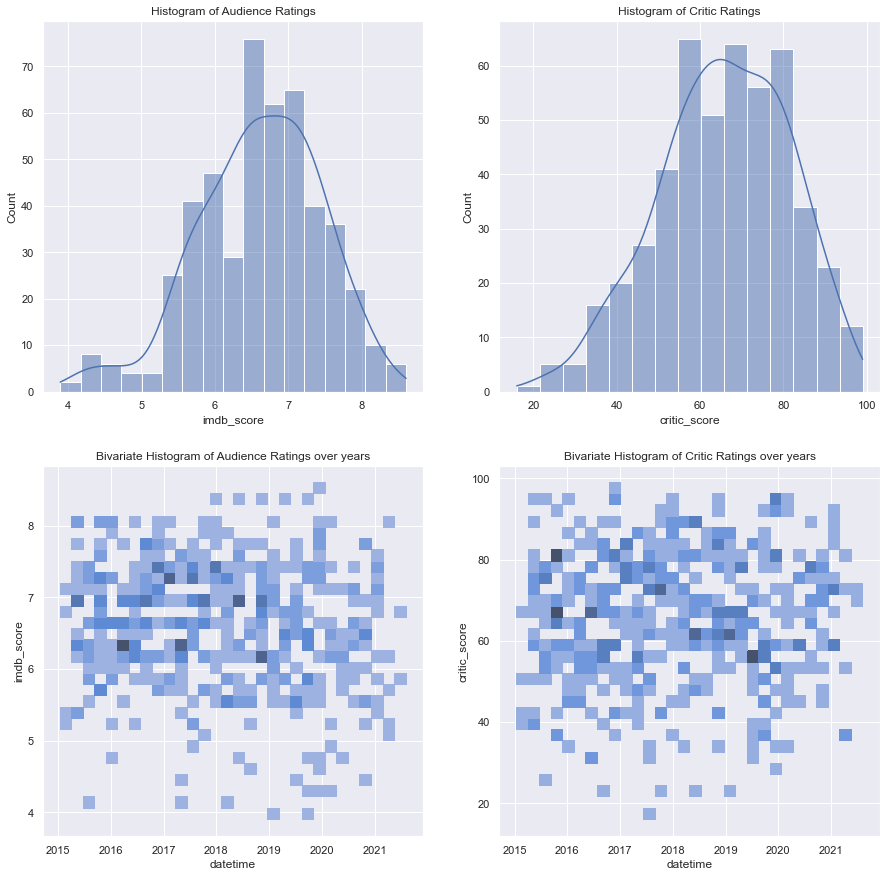

In [481]:
# visualize the distribution of cirtic score and imdb score
plt.rcParams['figure.figsize'] = 15, 15
plt.figure()

fig, ax = plt.subplots(2,2)

sns.histplot(data = df_movies[df_movies['imdb_score'] > 0],
                  x = 'imdb_score', 
                  ax = ax[0, 0],
                  kde = True).set_title("Histogram of Audience Ratings")

sns.histplot(data = df_movies[df_movies['critic_score'] > 0],
                  x = 'critic_score', 
                  ax = ax[0, 1],
                  kde = True).set_title("Histogram of Critic Ratings")
sns.histplot(df_movies[df_movies['imdb_score'] > 0], x="datetime", y="imdb_score",
    bins = 30, discrete=(False, False),
    ax = ax[1, 0]).set_title("Bivariate Histogram of Audience Ratings over years")

sns.histplot(df_movies[df_movies['critic_score'] > 0], x="datetime", y="critic_score",
    bins = 30, discrete=(False, False),
    ax = ax[1, 1]).set_title("Bivariate Histogram of Critic Ratings over years")

plt.show()

<Figure size 1080x864 with 0 Axes>

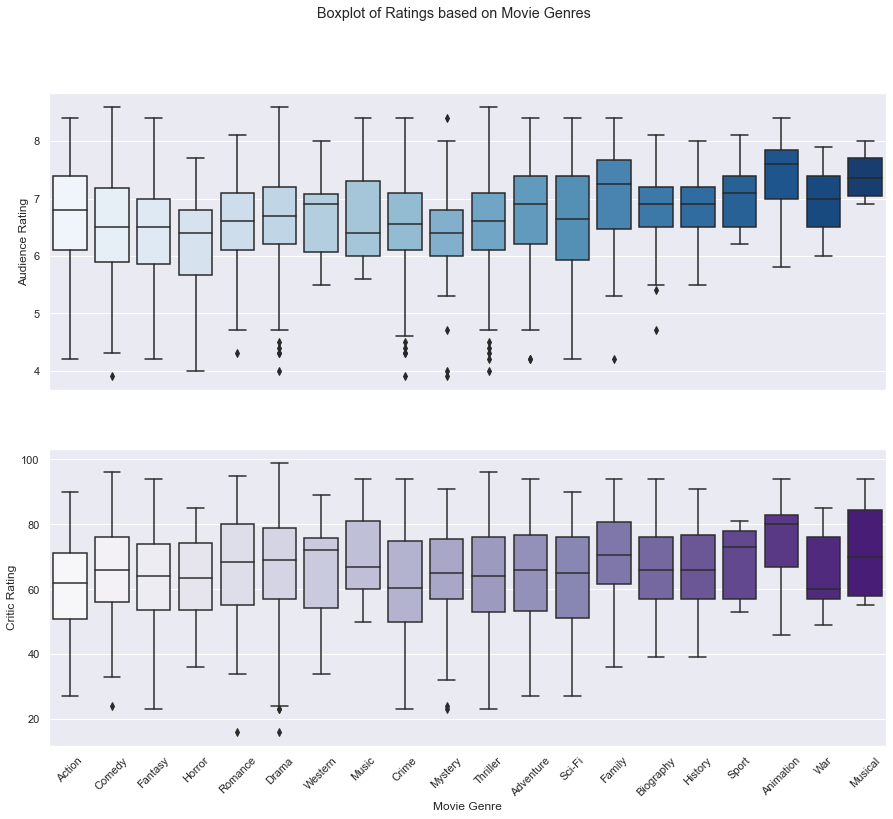

In [482]:
# box plot for critic rating and audience ratings
plt.rcParams['figure.figsize'] = 15, 12
plt.figure()

fig, ax = plt.subplots(2,1)

g1 = sns.boxplot(data=df_single_genres[df_single_genres['imdb_score'] > 0]
            ,x="single_genre", y="imdb_score", palette=("Blues"), ax = ax[0])
g1.set(xlabel=None)
g1.set(xticklabels=[])
g1.set(ylabel='Audience Rating')

sns.boxplot(data=df_single_genres[df_single_genres['critic_score'] > 0]
            ,x="single_genre", y="critic_score", palette=("Purples"), ax = ax[1])

plt.xlabel('Movie Genre')
plt.ylabel('Critic Rating')
plt.suptitle('Boxplot of Ratings based on Movie Genres')

plt.xticks(rotation = 45)
plt.show()

From the analysis of movie scores, we concludes some interesting findings:
1. Animation movies which are anticipated by the public tend to have good performance and meet people's expectations. It does make sense seem majority of animation movies are now produced by well-known brands or company such as Disney, Pixer and etc.
2. Critic scores have a larger variance, varying from 20 to 100, while imdb scores ranges from 4 to 9 (full score is 10).
3. There are not obvious positive or negative trend over years in both rating systems. 
4. Horror movies tend to have both lower critic scores and audience scores. It is not a suprising result since lots of horror movies in recent years are re-produced from previous versions, audience could have high anticipation because they their classic versions, though most of the re-produced horror movies perform a lot worse.

<a id='3.3'></a>
#### 3.3 Visualize Gross Distribution

<Figure size 1080x1296 with 0 Axes>

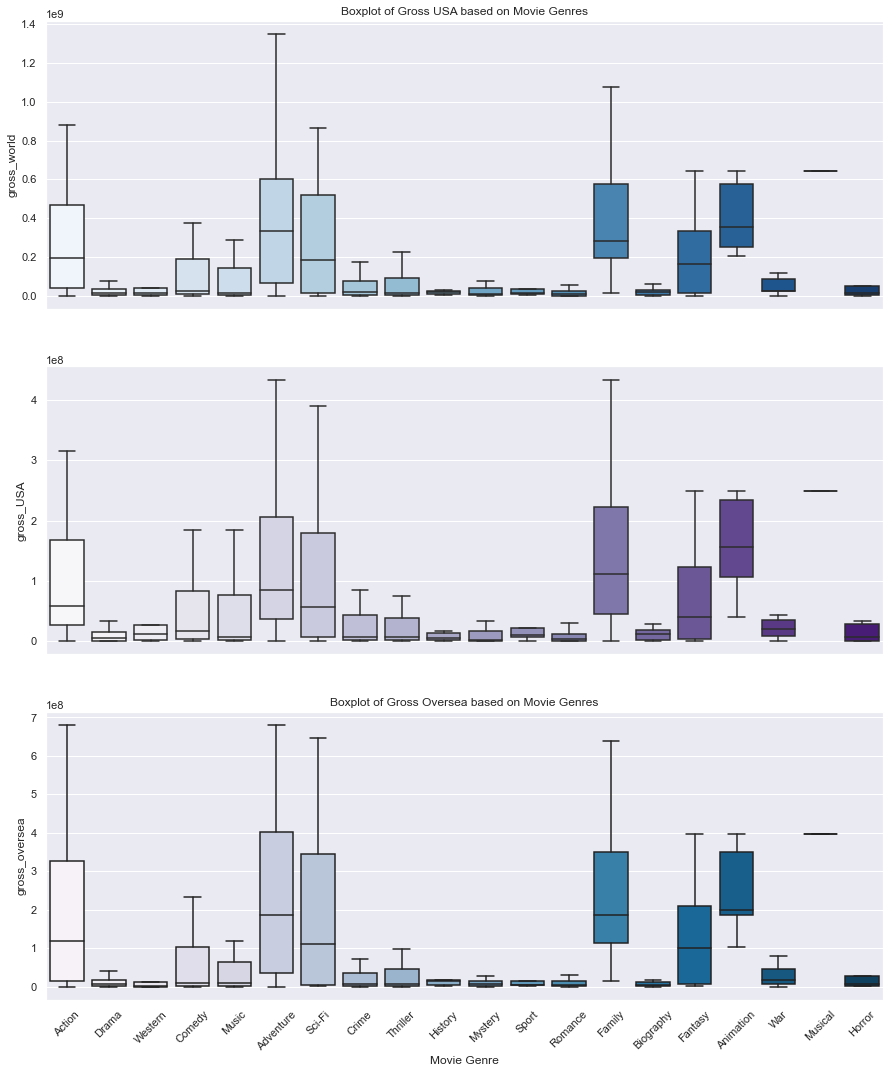

In [483]:
# create new feature gross_oversee
df_nonzero_gross = df_single_genres[(df_single_genres['gross_USA'] > 0) & df_single_genres['gross_world'] > 0]
df_nonzero_gross['gross_oversea'] = df_nonzero_gross['gross_world'] - df_nonzero_gross['gross_USA']

plt.rcParams['figure.figsize'] = 15, 18
plt.figure()

fig, ax = plt.subplots(3,1)

g1 = sns.boxplot(data = df_nonzero_gross
            ,x="single_genre", y="gross_world", palette=("Blues"),showfliers = False
            , ax = ax[0])
g1.set(xlabel=None)
g1.set(xticklabels=[])
g1.set(title = "Boxplot of Gross World based on Movie Genres")

g2 = sns.boxplot(data=df_nonzero_gross
            ,x="single_genre", y="gross_USA", palette=("Purples"),showfliers = False
            , ax = ax[1])
g2.set(xlabel=None)
g2.set(xticklabels=[])
g1.set(title = "Boxplot of Gross USA based on Movie Genres")

sns.boxplot(data= df_nonzero_gross
           ,x="single_genre", y="gross_oversea", palette=("PuBu"),showfliers = False
           , ax = ax[2])

plt.xlabel('Movie Genre')
plt.title("Boxplot of Gross Oversea based on Movie Genres")

plt.xticks(rotation = 45)
plt.show()

<Figure size 1080x1080 with 0 Axes>

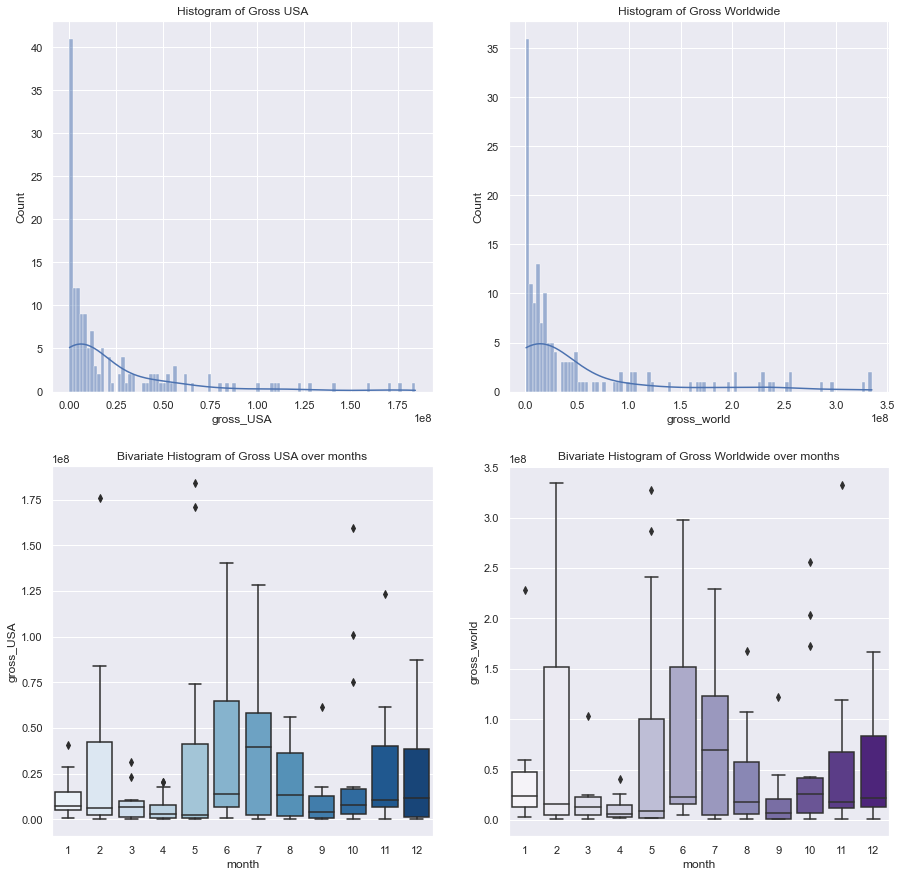

In [484]:
df_nonzero_gross = df_movies[(df_movies['gross_USA'] > 0) & df_movies['gross_world'] > 0]
df_nonzero_gross['month'] = pd.DatetimeIndex(df_nonzero_gross['datetime']).month
df_nonzero_gross = df_nonzero_gross[df_nonzero_gross['gross_world'].between(df_nonzero_gross['gross_world'].quantile(.10), df_nonzero_gross['gross_world'].quantile(.90))] 

# visualize the distribution of gross usa and gross world
plt.rcParams['figure.figsize'] = 15, 15
plt.figure()

fig, ax = plt.subplots(2,2)

sns.histplot(data = df_nonzero_gross,
                  x = 'gross_USA', 
                  ax = ax[0, 0], bins = 100, palette=("Blues"),
                  kde = True).set_title("Histogram of Gross USA")

sns.histplot(data = df_nonzero_gross,
                  x = 'gross_world', 
                  ax = ax[0, 1], bins = 100, palette=("Purples"),
                  kde = True).set_title("Histogram of Gross Worldwide")

sns.boxplot(data = df_nonzero_gross, x="month", y="gross_USA", palette=("Blues"),
    ax = ax[1, 0]).set_title("Bivariate Histogram of Gross USA over months")

sns.boxplot(data = df_nonzero_gross, x="month", y="gross_world",palette=("Purples"),
    ax = ax[1, 1]).set_title("Bivariate Histogram of Gross Worldwide over months")

plt.show()

From the visualization plots of movie revenues, we have some interesting findings:
1. Movies released during summer (June & July) or winter break (December or Feberurary) tend to have higher box office. 
2. Large variance in movie gross can be observed from the above histograms.
3. Animation movies generally have higher revenues as they are suitable to people at all ages (kids, old people, etc). Adventure, sci-fi, action and family movies are also perform well in their income gross. 
4. Movie catoriges performing well in the USA also perform well oversea. There are not huge differences in gross observed from the above box plots.

<a id='3.4'></a>
#### 3.4 Visualize movie trailer comments

Generate wordcloud from the comment in trailers of the worst 20 scored movies and the best 20 scored movies.

In [485]:
best_rated_movies = df_movies.sort_values(by = 'imdb_score', ascending = False)[:20]
worst_rated_movies = df_movies[df_movies['imdb_score'] > 0].sort_values(by = 'imdb_score')[:20]
print("Best rated movies are : ")
print(list(best_rated_movies['title']))
print()
print("Worst rated movies are : ")
print(list(worst_rated_movies['title']))

Best rated movies are : 
['Parasite', 'Avengers: Infinity War', 'Coco', 'Joker', 'Avengers: Endgame', 'Spider-Man: Into the Spider-Verse', 'Spotlight', 'Logan', 'Inside Out', 'The Wild Pear Tree', 'Room', 'Three Billboards Outside Ebbing, Missouri', 'The Handmaiden', 'Portrait of a Lady on Fire', 'Ford v Ferrari', 'Mad Max: Fury Road', 'La La Land', 'The Martian', 'The Mitchells vs the Machines', 'The Revenant']

Worst rated movies are : 
['Holmes & Watson', 'Wounds', 'Fantastic Four', 'Salt and Fire', 'A Wrinkle in Time', 'The Grudge', 'The Last Thing He Wanted', 'The Jesus Rolls', 'The Craft: Legacy', 'Domino', 'The Dinner', 'Slice', 'Like a Boss', 'Zoolander 2', 'Dark Crimes', 'Capone', "Charlie's Angels", 'Lucy in the Sky', 'Downhill', 'The Last Face']


In [486]:
df_trailer_comments = pd.read_csv("movie_trailer_comments.csv", index_col = 0, lineterminator='\n')

In [487]:
# start with best rated movies
# extract trailer comments for the best movies 
best_movies_comments = df_trailer_comments[df_trailer_comments.iloc[:,0].isin(list(best_rated_movies['title']))]
worst_movies_comments = df_trailer_comments[df_trailer_comments.iloc[:,0].isin(list(worst_rated_movies['title']))]

In [488]:
stopwords = set(STOPWORDS)
stopwords.update(["movie", "trailer", "video", "film", "films", "movies", "one", "seen", "see", "watched", "watch",
                 "will", "know"])

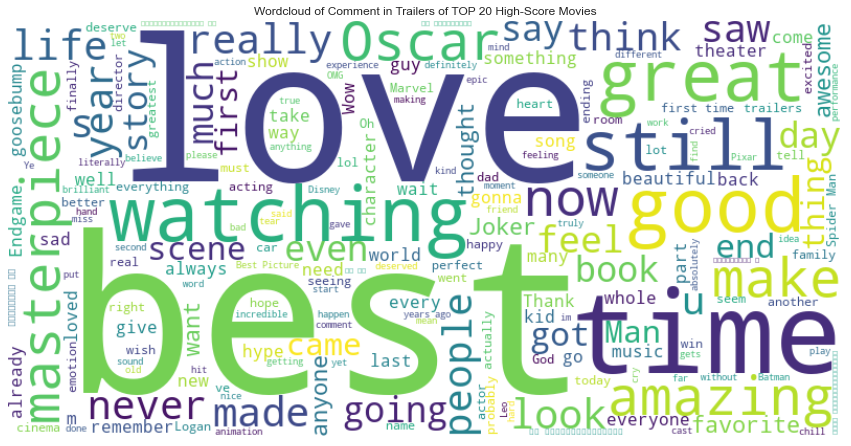

In [489]:
best_movies_trailer_text = ' '.join([str(c) for c in best_movies_comments['comment']])
best_movies_wordcloud = WordCloud(stopwords=stopwords, background_color="white", 
                      width=800, height=400).generate(best_movies_trailer_text)

plt.imshow(best_movies_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud of Comment in Trailers of TOP 20 High-Score Movies")
plt.show()

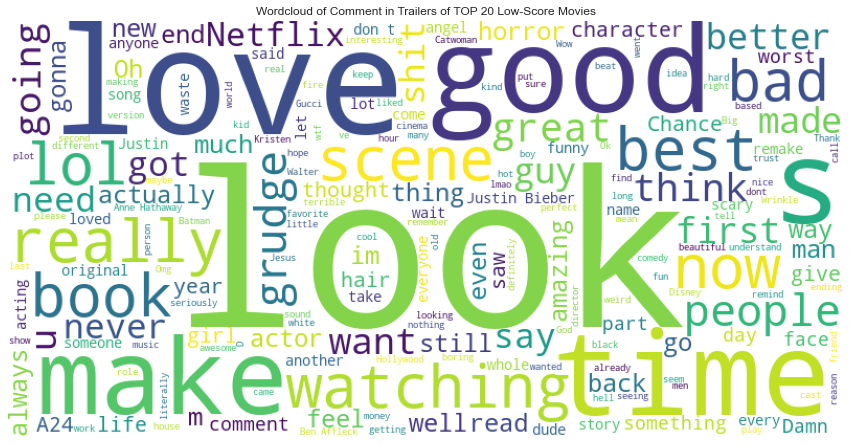

In [490]:
worst_movies_trailer_text = ' '.join([str(c) for c in worst_movies_comments['comment']])
worst_movies_wordcloud = WordCloud(stopwords=stopwords, background_color="white", 
                      width=800, height=400).generate(worst_movies_trailer_text)

plt.imshow(worst_movies_wordcloud)
plt.axis("off")
plt.title("Wordcloud of Comment in Trailers of TOP 20 Low-Score Movies")
plt.show()

After plotting the above word clouds, we notice that more positive words, such as 'masterpiece', 'Oscar', 'amazing' can be found in high-score movies. Though there are lost of positive words frequently appear under the comments of worst movie trailers, some negative words can also be spot on, such as 'worst' and 'damn'. This result indicates that trailer comemnt sentiments could have some impacts, but not large effects, on final movie scores. They could potentially be a small factor into predicting movie scores since it is possible that movie companies put a lot of effort into filming a good trailer to advertise their movies. Another interesting finding is words like 'horror' and 'scary' can be discovered in the wordcloud of top 20 low score movies. This reflects that movie in horror genres may tend to have lower scores.

<a id='part4'></a>
### Part 4 - Data Analysis on Quantified Features

<a id='4.1'></a>
#### 4.1 Merge Features

Since we have many useful movie attributes in different csv files, first we need to collect together all the data and build a complete dataframe.

In [72]:
# calculate average sentiment polarity scores for each movie
mean_sentiment = df_trailer_sentiments.drop(['subjectivity', 'sentiment'], axis= 1).groupby('title').mean()
mean_sentiment = mean_sentiment.reset_index()
mean_sentiment.head(3)

,title,polarity
0,20th Century Women,0.159305
1,45 Years,0.115688
2,A Beautiful Day in the Neighborhood,0.276792


In [78]:
df_trailer_ratings['like_counts'] = df_trailer_ratings['like_counts'].astype(float)
df_trailer_ratings['dislike_counts'] = df_trailer_ratings['dislike_counts'].astype(float)
# calculate like rate
df_trailer_ratings['like_rate'] = df_trailer_ratings['like_counts'] \
                    / (df_trailer_ratings['like_counts'] + df_trailer_ratings['dislike_counts'])
df_trailer_ratings.head(3)

,title,trailer_id,like_counts,dislike_counts,like_rate
0,Pride and Prejudice and Zombies,foGraEVNI0s,37816.0,4237.0,0.899246
1,American Ultra,bLGFwkRx2HA,31088.0,876.0,0.972594
2,Jane Got a Gun,fm7qxI3gmpw,2506.0,291.0,0.895960


In [81]:
# join the sentiment scores with quantified movie features
merged_sentiment = pd.merge(df_movies_quantified, mean_sentiment, left_on='title', right_on='title', how="outer")

# continue joining the video id rating with 
df_merged_features = pd.merge(merged_sentiment, 
                              df_trailer_ratings.drop(['trailer_id', 'like_counts', 'dislike_counts'], axis=1),
                             left_on = 'title',
                             right_on = 'title',
                             how = 'outer')
df_merged_features = df_merged_features.drop(df_merged_features.columns[0], axis = 1)
df_merged_features.head(3)

,title,imdb_id,genres,director,stars,release_date,budget,gross_USA,gross_world,production_co,imdb_score,critic_score,polarity,like_rate
0,Pride and Prejudice and Zombies,tt1374989,55.40,53.0,56.00,5-Feb-16,28000000,10938134,16457494,60.67,5.8,45,0.222787,0.899246
1,American Ultra,tt3316948,53.41,49.0,58.33,21-Aug-15,28000000,14440985,27262374,54.67,6.1,50,0.238267,0.972594
2,Jane Got a Gun,tt2140037,58.35,56.0,58.67,29-Jan-16,25000000,1513793,3067531,45.33,5.9,49,0.075035,0.895960


<a id = '4.2'></a>
#### 4.2 Examine Feature Correlation

Here, we use seaborn to plot the correlation between two features. First we have to determine the target feature. Notice that we have two kinds of movie scores in the dataframe, let's see their correlation. 

In [97]:
# drop data with no imdb_score or critic_score
df_merged_features = df_merged_features[(df_merged_features['imdb_score'] != 0)
                                       & (df_merged_features['critic_score'] != 0)]

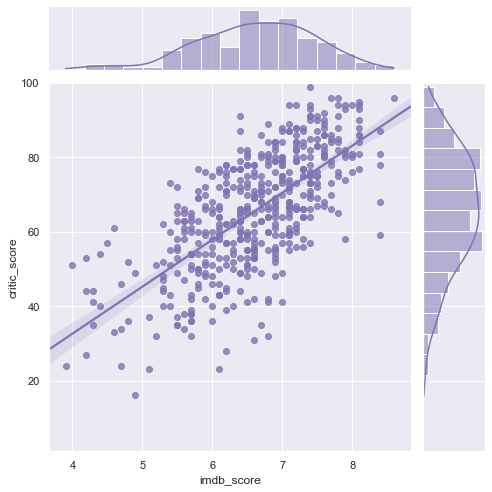

In [539]:
sns.jointplot(x="imdb_score", y="critic_score", data=df_merged_features,
                  kind="reg", truncate=False,
                  ylim=(1, 100),
                  color="m", height=7)

As wee can see, there is a strong correlation between imdb_score and critic_score, so predicting one of them will be enough. We will pick critic_score as the target feature, which is `y` in the future prediction.

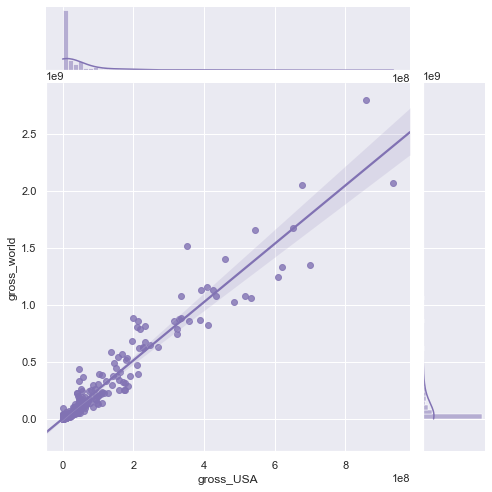

In [540]:
g = sns.jointplot(x="gross_USA", y="gross_world", 
                  data=df_merged_features[df_merged_features['gross_world'] != 0],
                  kind="reg", truncate=False,
                  color="m", height=7)

We can see movie gross in USA has strong linear relation with gross in the world, which makes common sense.

Next, we examine the correlation between each feature with target feature `critic_score`.

In [98]:
df_merged_features['release_date'] = pd.to_datetime(df_merged_features['release_date'],
                                                    format = '%d-%b-%-y',
                                                    infer_datetime_format=True)

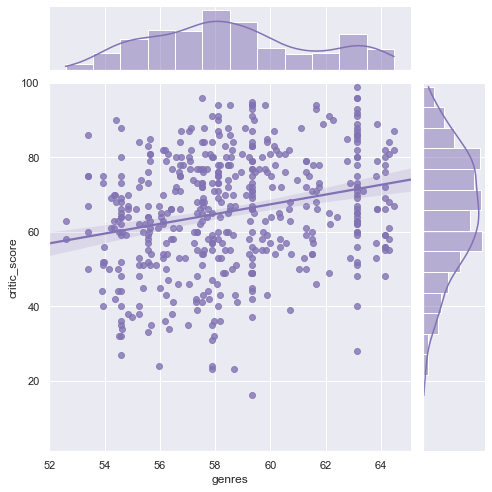

In [554]:
g = sns.jointplot(x="genres", y="critic_score", data=df_merged_features,
                  kind="reg", truncate=False,
                  ylim=(1, 100),
                  color="m", height=7)

Even though data points are distributed, the mean values of each genres seem to have linear relation with critic score, which is acceptable.

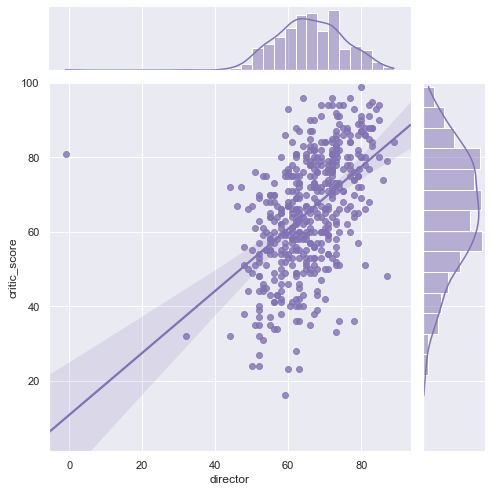

In [553]:
g = sns.jointplot(x="director", y="critic_score", data=df_merged_features,
                  kind="reg", truncate=False,
                  ylim=(1, 100),
                  color="m", height=7)

Director scores mostly are distributed between 40 and 80 and have a slope Director has positive correlation with critic score.

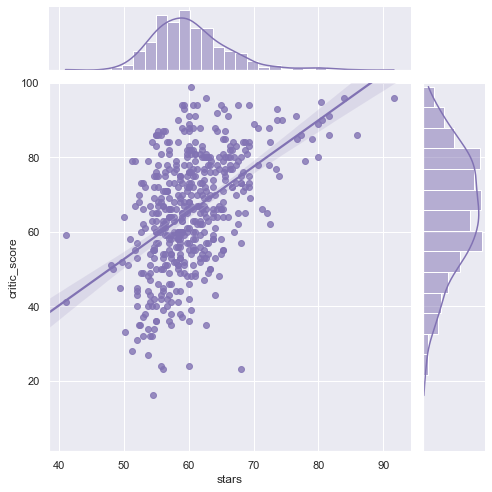

In [557]:
g = sns.jointplot(x="stars", y="critic_score", data=df_merged_features,
                  kind="reg", truncate=False,
                  ylim=(1, 100),
                  color="m", height=7)

Stars scores are mostly distributed between 50 and 70. However, we can still see a slope. In addition, the top right corner in the plot shows that all movies with high-score stars have the high critic scores, which is quite logical.

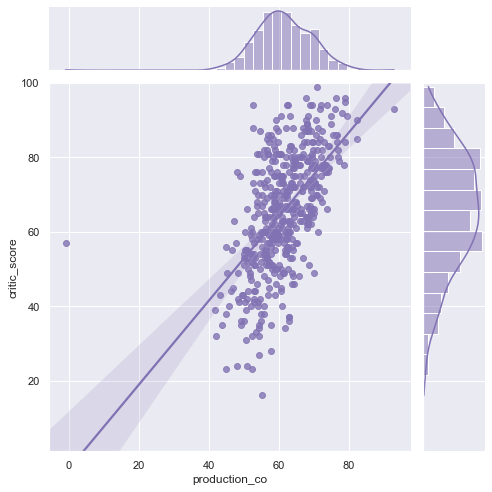

In [558]:
g = sns.jointplot(x="production_co", y="critic_score", data=df_merged_features,
                  kind="reg", truncate=False,
                  ylim=(1, 100),
                  color="m", height=7)

Most film company scores are distributed between 40 and 80. Also film company and critic score have a positive correlation.

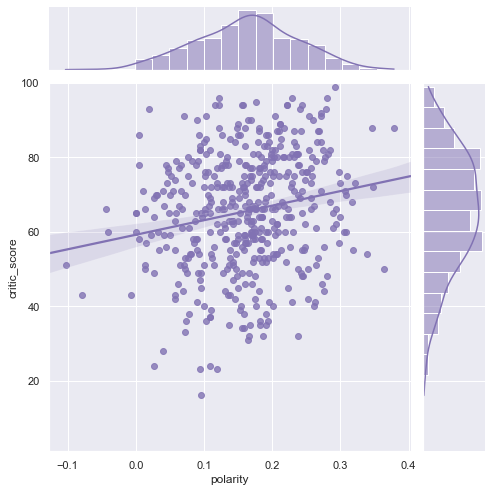

In [566]:
g = sns.jointplot(x="polarity", y="critic_score", data=df_merged_features,
                  kind="reg", truncate=False,
                  ylim=(1, 100),
                  color="m", height=7)

Polarity is what we get from trailer comment sentiment analysis. We can see there is a positive correlation between polarity and critic score.

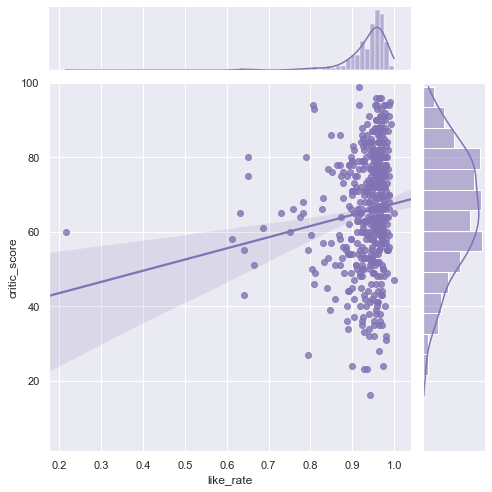

In [568]:
g = sns.jointplot(x="like_rate", y="critic_score", data=df_merged_features,
                  kind="reg", truncate=False,
                  ylim=(1, 100),
                  color="m", height=7)

Like rate is what we get from trailers' like and dislike count. From the plot, however, we can see even the movie with high like_rate can still have a low critic score. Seems like_rate doesn't have a strong correaltion with critic_score.

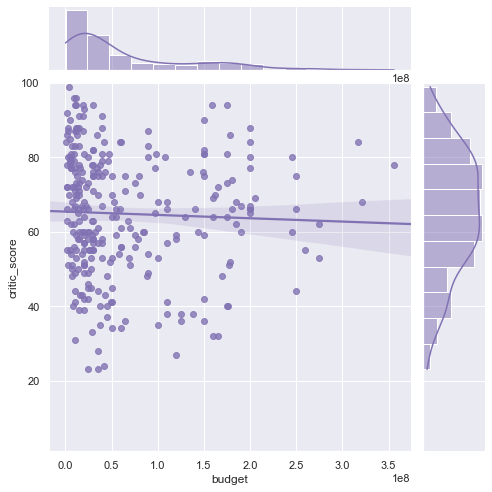

In [571]:
g = sns.jointplot(x="budget", y="critic_score", data=df_merged_features[df_merged_features['budget'] != 0],
                  kind="reg", truncate=False,
                  ylim=(1, 100),
                  color="m", height=7)

From the plot we can see a movie with small budget can still have a high critic score. And there is a negative correlation in the plot, which is counterintuitive. Thus, budget seems have weak correlation with critic score.

In conclusion, we will use critic score as the target feature. It seems like genres, director score, stars score, film company score and polarity all have strong correlation with critic score. Even though like rate didn't show a correlation with critic score, we think it is anyhow a logical feature. So we will leave it and see how it performs in the machine learning process. Gross is a good feature, but not logical. We can't know the gross when predicting an unreleased movie. So we drop it when making prediction. Budget seems not to have a reasonable correlation. Also, lots of movies in the dataframe have the missing value in budget feature. Therefore we drop it too.

The final features we leave and use for machine learning are `genres`,`stars`,`director`,`production_co`,`polarity`,`like_rate` and `critic_score`.

<a id = 'part5'></a>
### Part 5 - Build Machine Learning Models

First let's create the predict dataframe containing the aforementioned features.

In [179]:
predict_set = df_merged_features[['title','critic_score','genres','stars','director','production_co','polarity','like_rate']].copy()

# Notice that there are some missing values in the table. Here we use the mean value of each column to replace the missing values.
director_mean = predict_set[predict_set['director']!=-1]['director'].mean()
production_co_mean = predict_set[predict_set['production_co']!=-1]['production_co'].mean()
for i in range(len(predict_set)):
    if i in predict_set.index:
        if predict_set.loc[i]['director']==-1:
            predict_set.loc[i,'director'] = director_mean
        if predict_set.loc[i]['production_co']==-1:
            predict_set.loc[i,'production_co'] = production_co_mean
predict_set = predict_set.fillna(predict_set.mean()['polarity':])

In [180]:
predict_set.to_csv('predict_set.csv')
predict_set.head(3)

,title,critic_score,genres,stars,director,production_co,polarity,like_rate
0,Pride and Prejudice and Zombies,45,55.40,56.00,53.0,60.67,0.222787,0.899246
1,American Ultra,50,53.41,58.33,49.0,54.67,0.238267,0.972594
2,Jane Got a Gun,49,58.35,58.67,56.0,45.33,0.075035,0.895960


In [4]:
predict_set = pd.read_csv("predict_set.csv", index_col = 0)
predict_set.head(3)

,title,critic_score,genres,stars,director,production_co,polarity,like_rate
0,Pride and Prejudice and Zombies,45,55.40,56.00,53.0,60.67,0.222787,0.899246
1,American Ultra,50,53.41,58.33,49.0,54.67,0.238267,0.972594
2,Jane Got a Gun,49,58.35,58.67,56.0,45.33,0.075035,0.895960


<a id = '5.1'></a>
#### 5.1 Linear Model + Feature Selection / Regularization

In [5]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import MinMaxScaler

##### Multi-variable Linear Regression

In [9]:
X = predict_set.copy().drop(['title','critic_score'],axis=1)
y = predict_set['critic_score']

In [184]:
lr = linear_model.LinearRegression(fit_intercept=True,normalize=False, copy_X=True)
lr.fit(X,y)
# R2 score
lr_r2_score =lr.score(X,y) 
print('Linear Model:')
print('intercept:',lr.intercept_)
print('coef:', lr.coef_)
print('train r2 score:', lr_r2_score)

Linear Model:
intercept: -58.67597024368922
coef: [ 0.22333083  0.38640099  0.44407942  0.82119918 40.91940744  1.5339541 ]
train r2 score: 0.5066680929190739


In [185]:
#cross validate
lr_validation_r2 = cross_val_score(lr, X, y=y, scoring=None, cv=10)
lr_validation_r2 = lr_validation_r2.mean()
print('Linear Model:')
print('validation r2 score:', lr_validation_r2)

Linear Model:
validation r2 score: 0.45203123686800045


##### Ridge Regression

Ridge Model:
best alpha {'alpha': 0.1}
validation R2 score 0.48


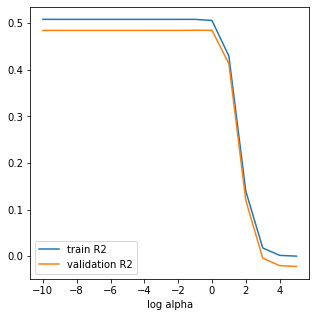

In [8]:
plt.rcParams['figure.figsize'] = 5, 5

scaler = MinMaxScaler()
scaler.fit(X)

# choose hyper parameter alpha
grid = {'alpha':[1e-10, 1e-9, 1e-6, 1e-5, 0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
ridge = Ridge()
ridgeCV = GridSearchCV(ridge,param_grid=grid,return_train_score=True)
ridgeCV.fit(scaler.transform(X), y)

print("Ridge Model:")
print('best alpha',ridgeCV.best_params_)
print('validation R2 score',ridgeCV.best_score_.round(2))

ridge = ridgeCV.best_estimator_
coef = pd.Series(ridge.coef_,index = X.columns)
coef.sort_values()

results = pd.DataFrame()
results['log alpha'] = np.log10(grid['alpha'])
results['train R2'] = ridgeCV.cv_results_['mean_train_score']
results['validation R2'] = ridgeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='log alpha',y='train R2')
results.plot.line(x='log alpha',y='validation R2',ax=ax1)
plt.show()

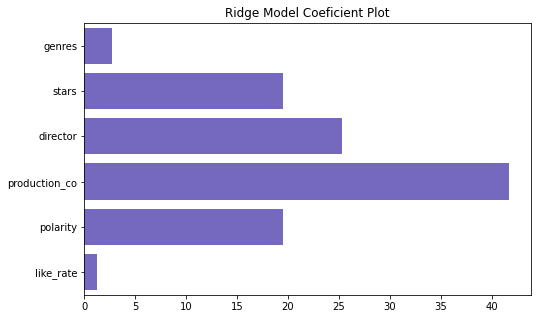

In [9]:
plt.rcParams['figure.figsize'] = 8,5
sns.barplot(y=X.columns, x = ridge.coef_, color="slateblue")
plt.title("Ridge Model Coeficient Plot")
plt.show()

##### Lasso Regression

In [10]:
from sklearn.linear_model import Lasso, LassoCV

Lasso Model:
best alpha {'alpha': 0.01}
validation R2 score 0.49


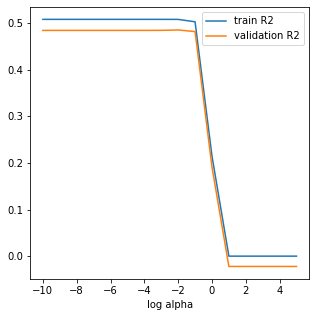

In [11]:
plt.rcParams['figure.figsize'] = 5, 5

# choose hyper parameter alpha
grid = {'alpha':[1e-10, 1e-9, 1e-6, 1e-5, 0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
lasso = Lasso()
lassoCV = GridSearchCV(lasso,param_grid=grid,return_train_score=True)
lassoCV.fit(scaler.transform(X), y)

print("Lasso Model:")
print('best alpha',lassoCV.best_params_)
print('validation R2 score',lassoCV.best_score_.round(2))

lasso = lassoCV.best_estimator_
coef = pd.Series(lasso.coef_,index = X.columns)
coef.sort_values()

results = pd.DataFrame()
results['log alpha'] = np.log10(grid['alpha'])
results['train R2'] = lassoCV.cv_results_['mean_train_score']
results['validation R2'] = lassoCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='log alpha',y='train R2')
results.plot.line(x='log alpha',y='validation R2',ax=ax1)
plt.show()

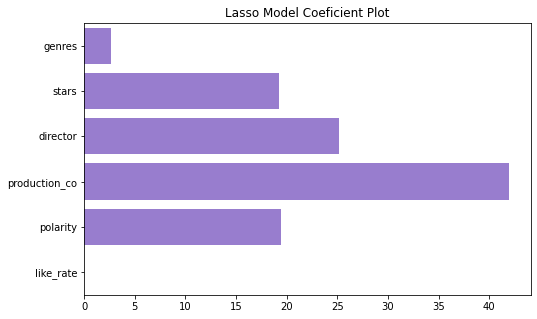

In [12]:
plt.rcParams['figure.figsize'] = 8,5
sns.barplot(y=X.columns, x = lasso.coef_, color="mediumpurple")
plt.title("Lasso Model Coeficient Plot")
plt.show()

<a id = '5.2'></a>
#### 5.2 Non-Linear Model (Polynomial Features)

In [6]:
from sklearn.preprocessing import PolynomialFeatures
X = predict_set[['genres','stars','director','production_co','polarity', 'like_rate']]

Run this on other computer 

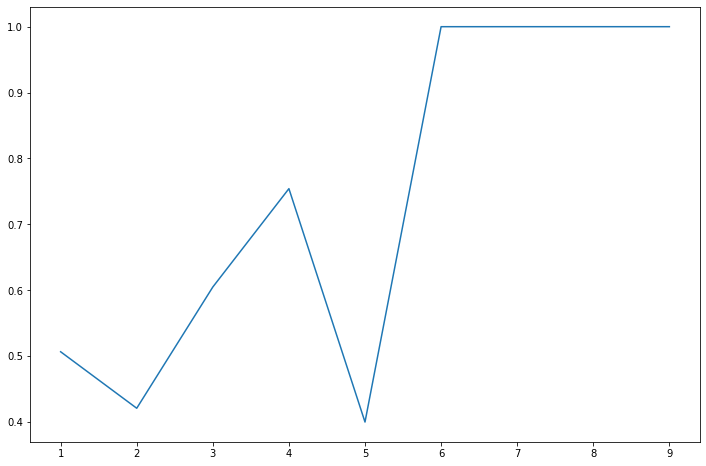

In [12]:
from sklearn.preprocessing import PolynomialFeatures
accs = []
for i in range(1,10):
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(X)
    reg = linear_model.LinearRegression(fit_intercept=True,normalize=False,copy_X=True,n_jobs=1)
    reg.fit(X_poly,y)
    acc=reg.score(X_poly,y)
    accs.append(acc)
#plot
plt.rcParams['figure.figsize'] = 12, 8
sns.lineplot(x=range(1,10), y=accs)
plt.show()

We can see when degree=4 our model has the best performance. Even though when degree>=6 the R2 score is perfect, it is unreasonable because of overfitting.

<a id = '5.3'></a>
#### 5.3 Non-Parametric Model

##### Random Forest

In [51]:
from sklearn.ensemble import RandomForestRegressor

best estimators {'n_estimators': 170}
valid R2 0.455


<AxesSubplot:xlabel='trees'>

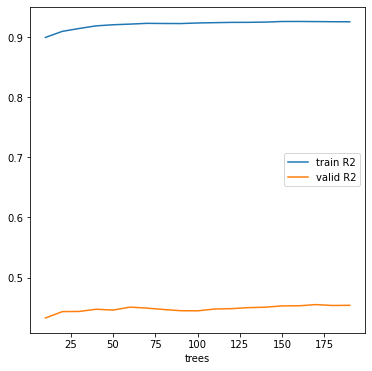

In [52]:
B = np.arange(10,200,10)
grid = {'n_estimators':B}

rf = RandomForestRegressor(random_state = 0)
rfCV = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)
rfCV.fit(X,y)
print('best estimators', rfCV.best_params_)
print('valid R2',rfCV.best_score_.round(3))

results = pd.DataFrame()
results['trees'] = grid['n_estimators']
results['train R2'] = rfCV.cv_results_['mean_train_score']
results['valid R2'] = rfCV.cv_results_['mean_test_score']
plt.rcParams['figure.figsize'] = 6, 6
ax1 = results.plot.line(x = 'trees',y = 'train R2')
results.plot.line(x='trees',y='valid R2',ax=ax1)

In [53]:
#Out of bag error estimation
rf = RandomForestRegressor(n_estimators = rfCV.best_params_['n_estimators'], oob_score = True, random_state = 0)
rf.fit(X,y)

cv_results = cross_validate(rf,X,y,return_train_score=True)
R2_trainCV = cv_results[('train_score')].mean()
R2_valid = cv_results[('test_score')].mean()
print('Random Forest Model:')
print('Out-of-Bag R2',rf.oob_score_.round(3))
print('train R2 (cv)',R2_trainCV.round(3))
print('valid R2 (cv)',R2_valid.round(3))

Random Forest Model:
Out-of-Bag R2 0.482
train R2 (cv) 0.926
valid R2 (cv) 0.455


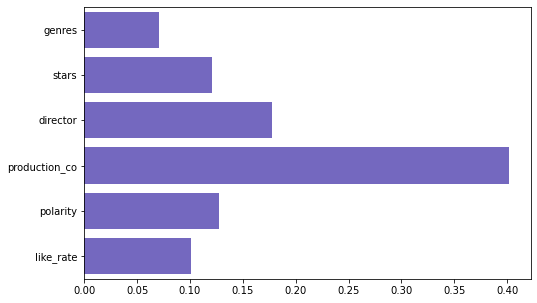

In [54]:
plt.rcParams['figure.figsize'] = 8, 5
sns.barplot(y=X.columns, x = rf.feature_importances_, color="slateblue")
plt.show()

<a id = '5.4'></a>
#### 5.4 Classification Model

Now turn the question into the classification one and see how machine leaning performs.

In [55]:
def f(x):
    if x>=85:
        return 'A'
    elif 70<=x<85:
        return 'B'
    elif 55<=x<70:
        return 'C'
    else:
        return 'R'
clf_y = y.apply(f)

In [62]:
print(clf_y.value_counts())

C    161
B    154
R    115
A     53
Name: critic_score, dtype: int64


##### Decision Tree with Bagging

In [59]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

tree=DecisionTreeClassifier(criterion='entropy', max_depth=None)
clf = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)
clf.fit(X,clf_y)
#cross validate
accs=cross_val_score(clf, X, y=clf_y, scoring=None, cv=10, n_jobs=1)
cross_score = accs.mean()
print("Decision Tree + Bagging: ")
print('Validation R2 score:',cross_score)

Decision Tree + Bagging: 
Validation R2 score: 0.4926020408163265


##### Naive Bayes

In [60]:
from sklearn import naive_bayes
clf = naive_bayes.GaussianNB()
clf.fit(X,clf_y)
#cross validate
accs=cross_val_score(clf, X, y=clf_y, scoring=None, cv=10, n_jobs=1)
cross_score = accs.mean()
print("Naive Bayes")
print('Validation R2 score:',cross_score)

Naive Bayes
Validation R2 score: 0.5298894557823128


In conclusion, when considering this prediction as a regressor problem, **Lasso Model** (Linear Model + regularization) has the best performance, with a validation R2 score of 0.49. When turning this problem into a classification perdication, the Naive Bayes models outperforms the decision tree (+bagging) model, with validation r2 score as high as 0.53. 

Most of the models have consensus on feature importance. The most important movie feature is agreed to be the **production company**.

<a id = 'part6'></a>
### Part 6 - A Fun Prediction

There are some movies in the 2020 most anticipated movie list which has not been released yet due to COVID. It would be interesting to take a look at their prediction results and see if the predicted ratings align with the actual results. We use Lasso Model for this fun prediction.

In [164]:
df_to_predict = pd.merge(merged_sentiment, 
                          df_trailer_ratings.drop(['trailer_id', 'like_counts', 'dislike_counts'], axis=1),
                         left_on = 'title',
                         right_on = 'title',
                         how = 'outer')
df_to_predict['year'] = df_to_predict['release_date'].apply(lambda x : x.split("-")[-1])
df_to_predict = df_to_predict[df_to_predict['year'] == '21']
# drop the NaN
df_to_predict = df_to_predict.dropna()
# drop director score / stars / production_co == -1
df_to_predict = df_to_predict[df_to_predict['director'] != -1]
df_to_predict = df_to_predict[df_to_predict['stars'] != -1]
df_to_predict = df_to_predict[df_to_predict['production_co'] != -1]
df_to_predict = df_to_predict[df_to_predict['critic_score'] == 0]
df_to_predict.head(3)

,Unnamed: 0.1,title,imdb_id,genres,director,stars,release_date,budget,gross_USA,gross_world,production_co,imdb_score,critic_score,polarity,like_rate,year
397,397,Benedetta,tt6823148,62.11,53.0,58.33,9-Jul-21,0,0,0,61.00,0.0,0,0.118077,0.903846,21
401,401,The Woman in the Window,tt6111574,57.34,63.0,55.33,14-May-21,0,0,0,53.67,0.0,0,0.246292,0.986167,21
429,429,Antlers,tt7740510,56.52,68.0,58.01,29-Oct-21,0,0,0,56.67,0.0,0,0.098547,0.971003,21


In [165]:
X_test = df_to_predict[['genres', 'stars', 'director', 'production_co', 'polarity', 'like_rate']]
predicted_score = lasso.predict(scaler.transform(X_test))

In [166]:
df_to_predict['predicted_critic_score'] = predicted_score

<AxesSubplot:xlabel='predicted_critic_score', ylabel='title'>

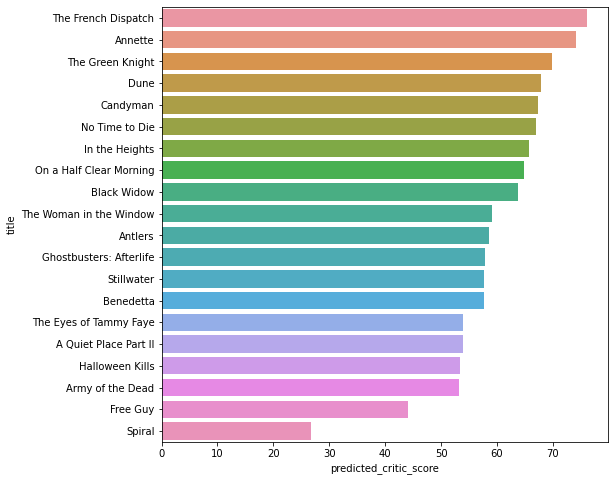

In [174]:
plt.rcParams['figure.figsize'] = 8, 8
sns.barplot(y = 'title', x ='predicted_critic_score', data =df_to_predict.sort_values(by = 'predicted_critic_score', ascending = False))

From the result, The French Dispatch wins the champion. Actually, it is what I expected. Its director Wes Anderson is a talented one. His famous movie `The Grand Budapest Hotel` has won many awards. Its stars, Adrien Brody and Tilda Swinton are also my favorite actor and actress. As for the rest of the list, whether the ranking is accurate or not, let's wait and see!

<a id = 'part7'></a>
### Part 7 - Conclusion

We collect the most anticipated movies selected by the Playlist website and extract movie variables from IMDb application and from the official movie trailer on Youtube.

We apply some basic data mining techniques to explore the collected dataset. We start by analyzing data distribution and trailer comments. Then, we try to quantify categorical features by averaging the scores collected from the meteoritic website. We also apply sentiment analysis on trailer comments to get overall polarity score for each movie.

Last, we build machine learning models to predict movie critic scores. We first examine feature correlations. Then we applied multiple types of machine learning models. In this process, we adopted cross validation to prevent overfitting and to tune hyper-parameter. The maximum r2 score is found to be 0.49 by using Lasso Model. 

<a id = 'part7'></a>
### Part 7 - Future Work Suggestion

1. We have not built a machine learing model that is robust enough to predict imdb scores. The best r2 score so far is 0.49. Future work are needed to improve the model performance:

    1). As you may notice, we did not take twitter comments into account when training models. This is beacuse there are lots of advertisements our extracted tweets which we think are negatively impacting our overall twitter data effectiveness. More data cleaning work are needed to apply to collected tweets. It would be better if another extraction approach can be discovered. Right now, we simply search all the tweets related to the movie titles before release dates. More restrictions should be applied. Or future work should extract tweets under movie twitter tags or accounts.
    
    2). In addition to consider audience voice and sentiments under movie trailers, critics' voices are also needed to be taken into account. Plus, a good movie usually has good writers. So 'writer' could be added as an additional feature. Some other features that could be considered into model training include 'whether movie is a collection', 'whether movie is adapted from a fiction' and etc.
    
    3). 'Like-rate' suprisingly has small impact into prediction. We think the reason could be that we only used one movie trailer as reference. Since movie companies always release multiple trailer versions on Youtube. Next time, all movie trailers should be considered and the extracted results can be averaged as one feature.
    
    
2. Future work are needed in extracting movie budget attributes. Right now, a lot of movies are missing budget features so we are unable to predict the revenues of upcoming movies. IMDb websites are short of budget data so next time, we should extract such data from a more reliable source such as wikipedia.

### References:

1. Seaborn Library: https://seaborn.pydata.org/index.html
2. TextBlob Library: https://textblob.readthedocs.io/en/dev/
3. WordCloud Library: https://amueller.github.io/word_cloud/
4. YouTube Data API: https://developers.google.com/youtube/v3
5. Stweets Library: https://github.com/markowanga/stweet
6. IMDb website: https://www.imdb.com/
7. Metacritic reviews: https://www.metacritic.com/
8. Sklearn Library: https://scikit-learn.org/stable/index.html